In [1]:
import pickle
from pandarallel import pandarallel
pandarallel.initialize(use_memory_fs=False)
import numpy as np 
import pandas as pd
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import argparse
import os 
import glob
from collections import namedtuple, defaultdict

import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
model_name = "v16_elegammasep"
model_dir = "../models/"+model_name

model_version = 1
numpy_version = 1
files_ele = f"/storage/ECAL/training_data/wp_comparison/electrons/numpy_wp_ele_v1/training/"
limit_files = 20

cols = ["seed_eta", "seed_iz","en_seed","et_seed",
        "cluster_deta", "cluster_dphi", "en_cluster", "et_cluster",
       "seed_f5_r9", "seed_f5_sigmaIetaIeta","seed_f5_sigmaIetaIphi","seed_f5_sigmaIphiIphi",
        "seed_f5_swissCross","seed_nxtals", "seed_etaWidth", "seed_phiWidth",
        "cl_f5_r9", "cl_f5_sigmaIetaIeta","cl_f5_sigmaIetaIphi","cl_f5_sigmaIphiIphi",
        "cl_f5_swissCross", "cl_nxtals", "cl_etaWidth", "cl_phiWidth"]


In [3]:
from keras.models  import load_model

model_EB = load_model(model_dir + f"/model_v{model_version}_EB_ele.hd5")
model_EE = load_model(model_dir + f"/model_v{model_version}_EE_ele.hd5")
scaler_EB = pickle.load(open(model_dir + f"/scaler_model_v{model_version}_EB_ele.pkl", "rb"))
scaler_EE = pickle.load(open(model_dir + f"/scaler_model_v{model_version}_EE_ele.pkl", "rb"))


Using TensorFlow backend.


Including only clusters where the seed is calomatched

In [3]:
datas_ele = []

i = 0
for f in glob.glob(files_ele+"*.pkl"):
    if i>limit_files :continue
    d = pickle.load(open(f, "rb"))   
    datas_ele.append( d[(d.is_seed_calo_matched == True)] )
    i+=1
    
data = pd.concat(datas_ele, ignore_index=True)
print("N events ele: ",len(data))

    

N events ele:  6396025


In [4]:
print('EB')
data.loc[data.seed_iz==0, "y"] = model_EB.predict(scaler_EB.transform(data[data.seed_iz==0][cols].values), batch_size=4096)
print('EE')
data.loc[data.seed_iz!=0, "y"] = model_EE.predict(scaler_EE.transform(data[data.seed_iz!=0][cols].values), batch_size=4096)

EB


NameError: name 'model_EB' is not defined

In [7]:
data.columns

Index(['calo_seed_index', 'cl_etaWidth', 'cl_f5_r9', 'cl_f5_sigmaIetaIeta',
       'cl_f5_sigmaIetaIphi', 'cl_f5_sigmaIphiIphi', 'cl_f5_swissCross',
       'cl_nxtals', 'cl_phiWidth', 'cluster_deta', 'cluster_dphi',
       'cluster_iz', 'en_cluster', 'en_cluster_calib', 'en_seed',
       'en_seed_calib', 'en_true', 'et_cluster', 'et_cluster_calib', 'et_seed',
       'et_seed_calib', 'et_true', 'in_geom_mustache', 'in_mustache',
       'in_scluster', 'is_calo_matched', 'is_seed', 'is_seed_calo_matched',
       'is_seed_mustached_matched', 'mustache_seed_index', 'seed_eta',
       'seed_etaWidth', 'seed_f5_r9', 'seed_f5_sigmaIetaIeta',
       'seed_f5_sigmaIetaIphi', 'seed_f5_sigmaIphiIphi', 'seed_f5_swissCross',
       'seed_iz', 'seed_nxtals', 'seed_phi', 'seed_phiWidth', 'window_index'],
      dtype='object')

In [8]:
data.window_index.unique().shape

(804139,)

In [10]:
data_must = data[data.is_seed_mustached_matched]

In [12]:
from multiprocessing import Pool

def analyze(group):
    grid,g = group
    
    data_calo = defaultdict(list)
    true_en = g.en_true.values[0]
    in_sc_true = np.cast['int32'](g.in_scluster.values)
    
    #do not count seeds for the ncls metrics
    nclusters = len(g) -1
    
    
    mask = np.cast['int32']((g.in_mustache))
    mask_withseed = np.cast['int32']((g.in_mustache)| (g.is_seed))

    pred_en =  np.sum(g.en_cluster.values * mask_withseed, axis=-1)

    tp =  np.cast['int32']((in_sc_true * mask_withseed) ==1)
    fp =  np.cast['int32']((in_sc_true - mask_withseed) <0)
    fn =  np.cast['int32']((in_sc_true - mask_withseed) >0)

    E_tp = np.sum(g.en_cluster.values * tp, axis=-1)
    E_fp = np.sum(g.en_cluster.values * fp, axis=-1)
    E_fn = np.sum(g.en_cluster.values * fn, axis=-1)

    data_calo['seed_eta'].append(g.seed_eta.values[0])
    data_calo['seed_en'].append(g.en_seed.values[0])
    data_calo['seed_et'].append(g.et_seed.values[0])
    data_calo['ncls'].append(nclusters)
    data_calo['ncls_sel'].append(np.sum(mask_withseed, axis=-1) - 1)
    data_calo['ncls_true'].append(np.sum(in_sc_true,axis=-1)-1)
    data_calo['ncls_sel_true'].append(np.sum(tp,axis=-1) -1 )
    data_calo['seed_sel'].append( int(mask[g.is_seed.values][0]==1) )
    data_calo['EoEtrue'].append( pred_en / true_en)
    data_calo['Etrue'].append(true_en)
    data_calo['Epred'].append(pred_en)
    data_calo['E_tp'].append(E_tp)
    data_calo['E_fp'].append(E_fp)
    data_calo['E_fn'].append(E_fn)
    return(data_calo)

pool = Pool(6)
data_calos = pool.map(analyze, data_must.groupby('window_index', sort=False))
    
    

In [13]:
data_calos

[defaultdict(list,
             {'seed_eta': [-1.5677804946899414],
              'seed_en': [214.77279663085938],
              'seed_et': [85.831885479732],
              'ncls': [2],
              'ncls_sel': [1],
              'ncls_true': [1],
              'ncls_sel_true': [1],
              'seed_sel': [1],
              'EoEtrue': [0.9953103816454467],
              'Etrue': [218.35621643066406],
              'Epred': [217.33220911026],
              'E_tp': [217.33220911026],
              'E_fp': [0.0],
              'E_fn': [0.0]}),
 defaultdict(list,
             {'seed_eta': [0.9756220579147339],
              'seed_en': [51.86598587036133],
              'seed_et': [34.23752001264564],
              'ncls': [7],
              'ncls_sel': [1],
              'ncls_true': [2],
              'ncls_sel_true': [1],
              'seed_sel': [1],
              'EoEtrue': [0.9381612844559252],
              'Etrue': [62.82096862792969],
              'Epred': [58.9362006187439],

In [14]:
data_final_calo = {}

for k in data_calos[0].keys():
    data_final_calo[k] = np.concatenate([l[k] for l in data_calos])

In [15]:
dfc = pd.DataFrame(data_final_calo)

In [17]:
dfc

,seed_eta,seed_en,seed_et,ncls,ncls_sel,ncls_true,ncls_sel_true,seed_sel,EoEtrue,Etrue,Epred,E_tp,E_fp,E_fn
0,-1.567780,214.772797,85.831885,2,1,1,1,1,0.995310,218.356216,217.332209,217.332209,0.000000,0.000000
1,0.975622,51.865986,34.237520,7,1,2,1,1,0.938161,62.820969,58.936201,58.936201,0.000000,0.799801
2,-0.678255,20.753859,16.750907,6,3,2,2,1,0.950007,34.942646,33.195758,32.724993,0.470765,0.000000
3,-2.761141,430.255737,54.184609,0,0,0,0,1,0.987182,435.842346,430.255737,430.255737,0.000000,0.000000
4,-0.724205,60.287922,47.325473,3,0,0,0,1,0.970471,62.122326,60.287922,60.287922,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
784626,-1.003359,26.743229,17.286742,7,1,1,1,1,0.956241,40.824005,39.037586,39.037586,0.000000,0.000000
784627,-2.226459,276.047913,58.890813,3,0,0,0,1,0.971173,284.241730,276.047913,276.047913,0.000000,0.000000
784628,1.004301,68.684143,44.365311,3,1,0,0,1,0.997744,69.125084,68.969165,68.684143,0.285022,0.000000
784629,-0.520376,26.544329,23.315611,13,2,2,2,1,0.961431,47.763058,45.920883,45.920883,0.000000,0.000000


In [ ]:
data_final_calo = {}
data_final_nocalo = {}

for k,v in data_calos.items():
    data_final_calo[k] = np.concatenate(v)
    
for k,v in data_nocalo.items():
    data_final_nocalo[k] = np.concatenate(v)
    
import pandas as pd
dfc = pd.DataFrame(data_final_calo)
dfnc = pd.DataFrame(data_final_nocalo)

In [67]:
dfc = pd.DataFrame(data_calo)

In [19]:
import pickle
pickle.dump(dfc, open("df_calomatched_match_mustach.pkl","wb"))

In [21]:
from collections import defaultdict
import matplotlib.colors as colors
import matplotlib.pyplot as plt

#mport mplhep as hep
#lt.style.use(hep.style.CMS)

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (5,4)
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams["image.origin"] = 'lower'

In [22]:
ets = [0,5,10,15, 20,40,60,80,100]
etas = [0, 0.4,0.8, 1.2,1.479, 1.75,2.,2.3,2.6,3]
ncls = [0,2,3,5,10,15,20,25,30,35,50]

dfc["eta_bin"] = pd.cut(abs(dfc.seed_eta), etas, labels=list(range(len(etas)-1)))
dfc["et_bin"] = pd.cut(dfc.seed_et, ets, labels=list(range(len(ets)-1)))
dfc["ncls_bin"] = pd.cut(dfc.ncls, ncls, labels=list(range(len(ncls)-1)))

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


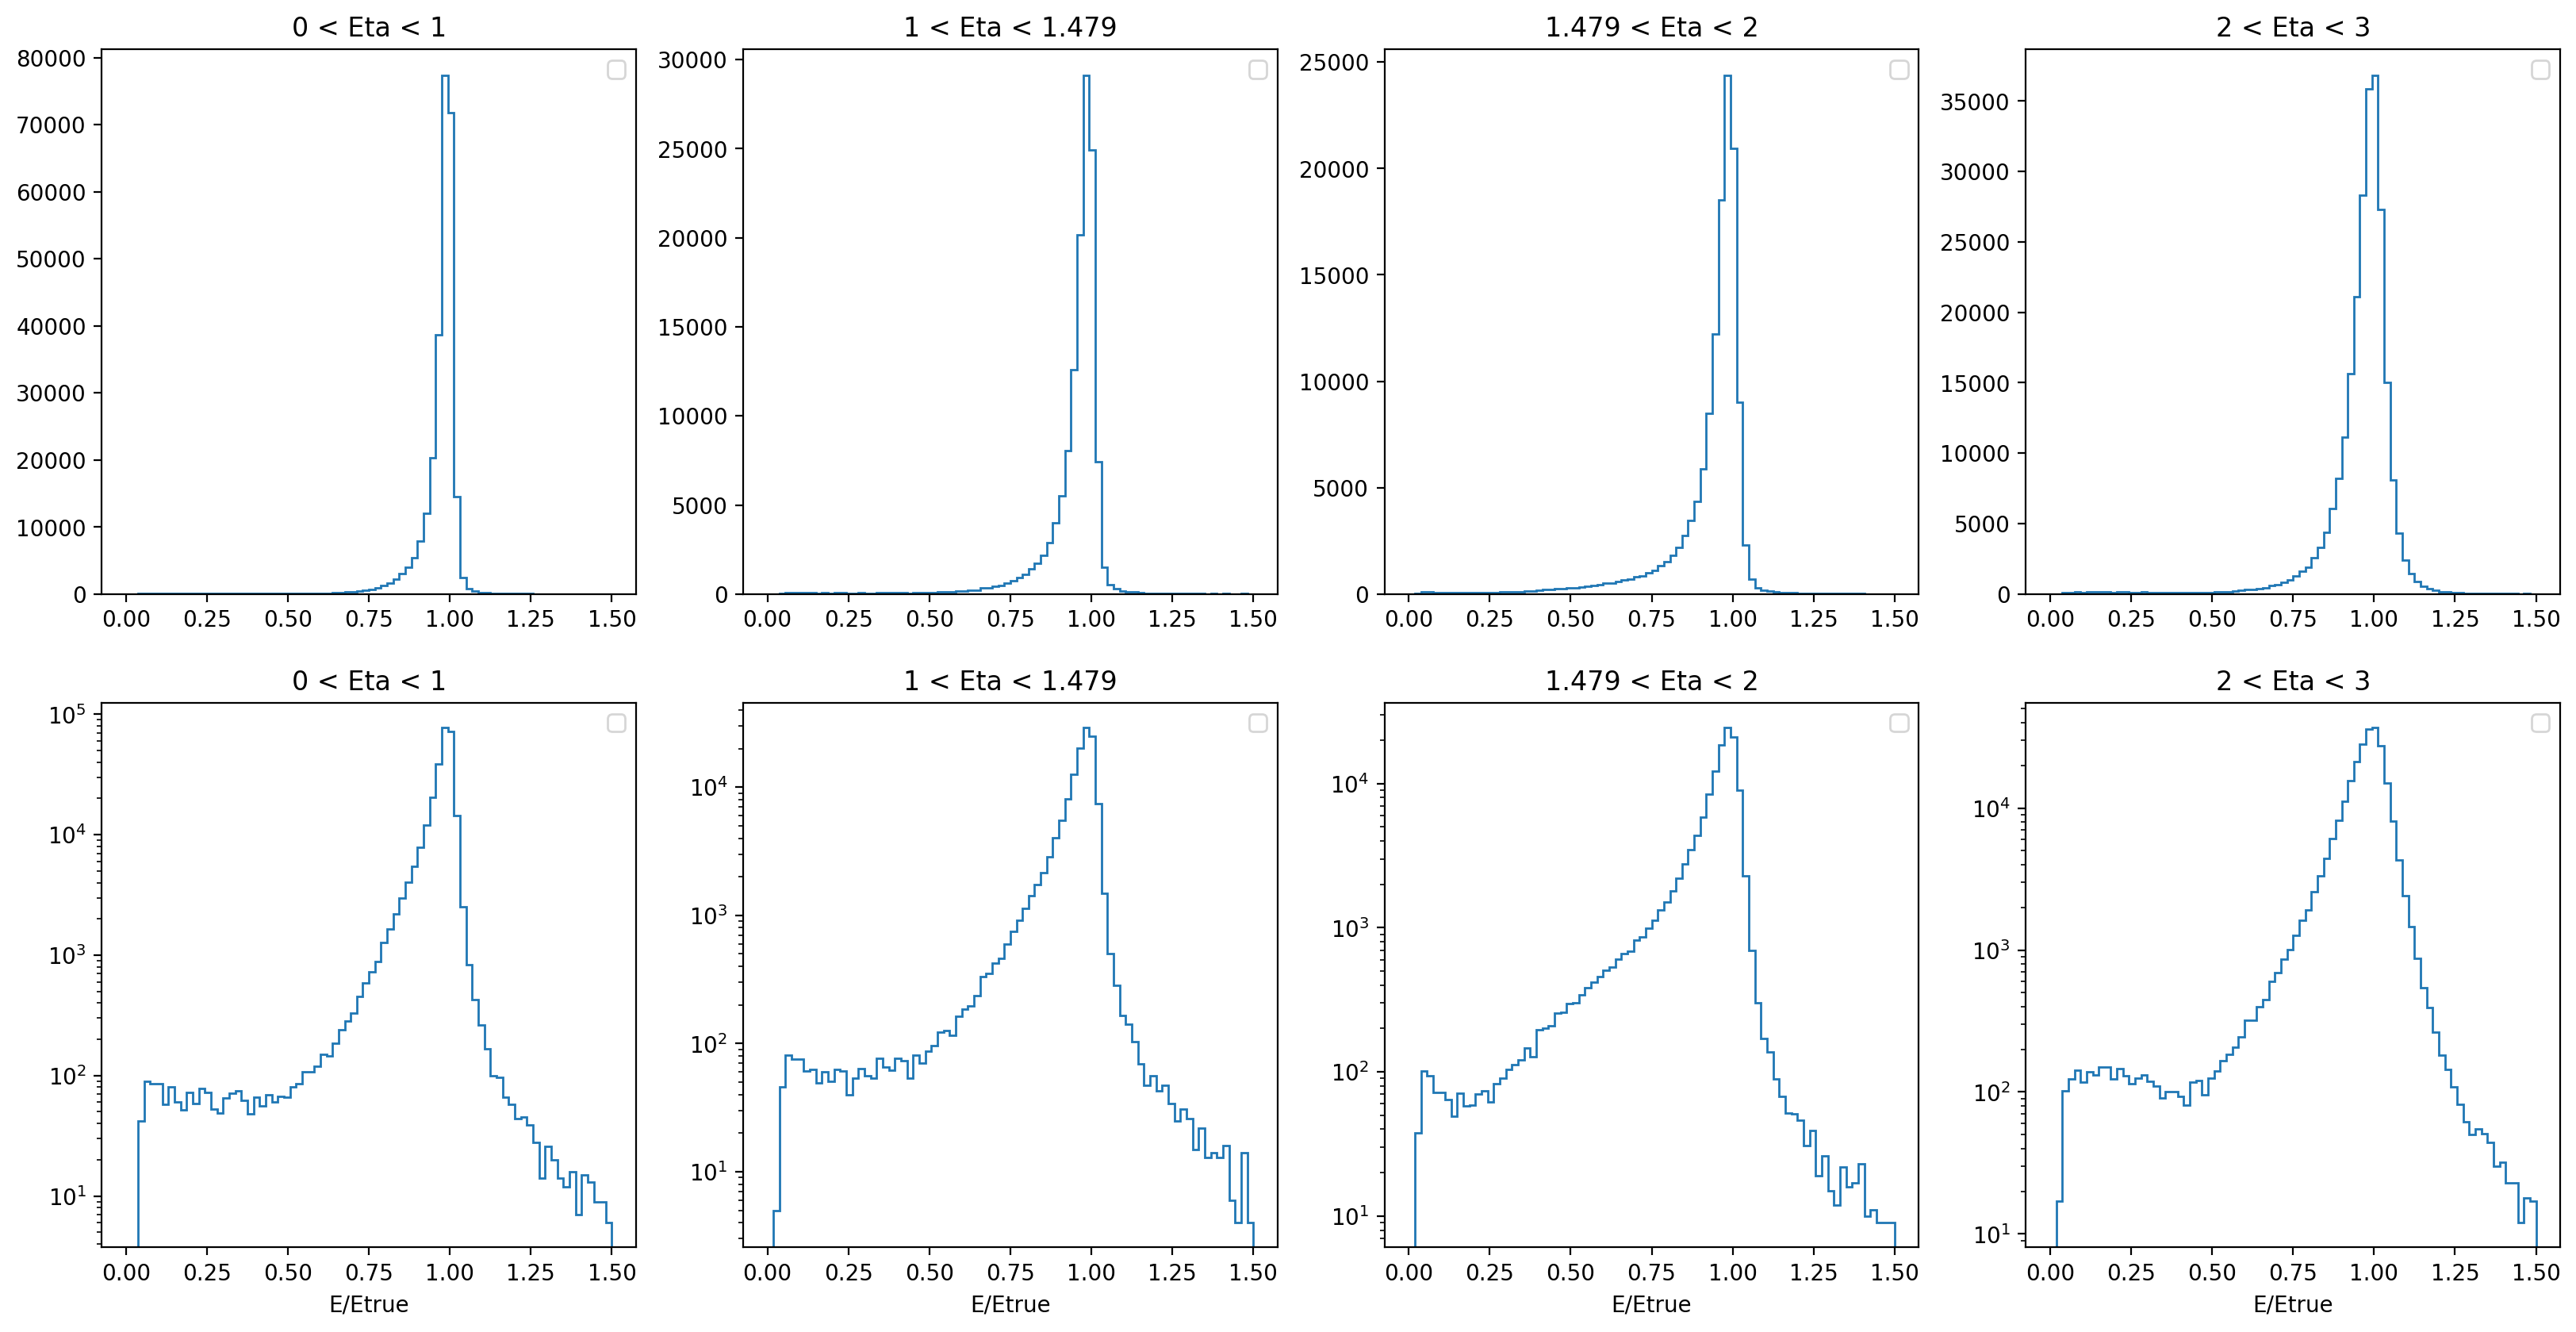

In [24]:
fig, ax = plt.subplots(2,4, figsize=(20,10),dpi=200)

etas = [ (0,1),(1,1.479),(1.479,2), (2,3)]

for j,(e1,e2) in enumerate(etas): 
    ax[0,j].hist(dfc[(abs(dfc.seed_eta)>=e1) & (abs(dfc.seed_eta)<e2)].EoEtrue,bins=80, range=(0,1.5),histtype='step')
    ax[0,j].legend()
    ax[0,j].set_title('{} < Eta < {}'.format(e1,e2))   
    ax[1,j].hist(dfc[(abs(dfc.seed_eta)>=e1) & (abs(dfc.seed_eta)<e2)].EoEtrue,bins=80, range=(0,1.5),histtype='step')
    ax[1,j].legend()
    ax[1,j].set_xlabel("E/Etrue")
    ax[1,j].set_title('{} < Eta < {}'.format(e1,e2))  
    ax[1,j].set_yscale('log')



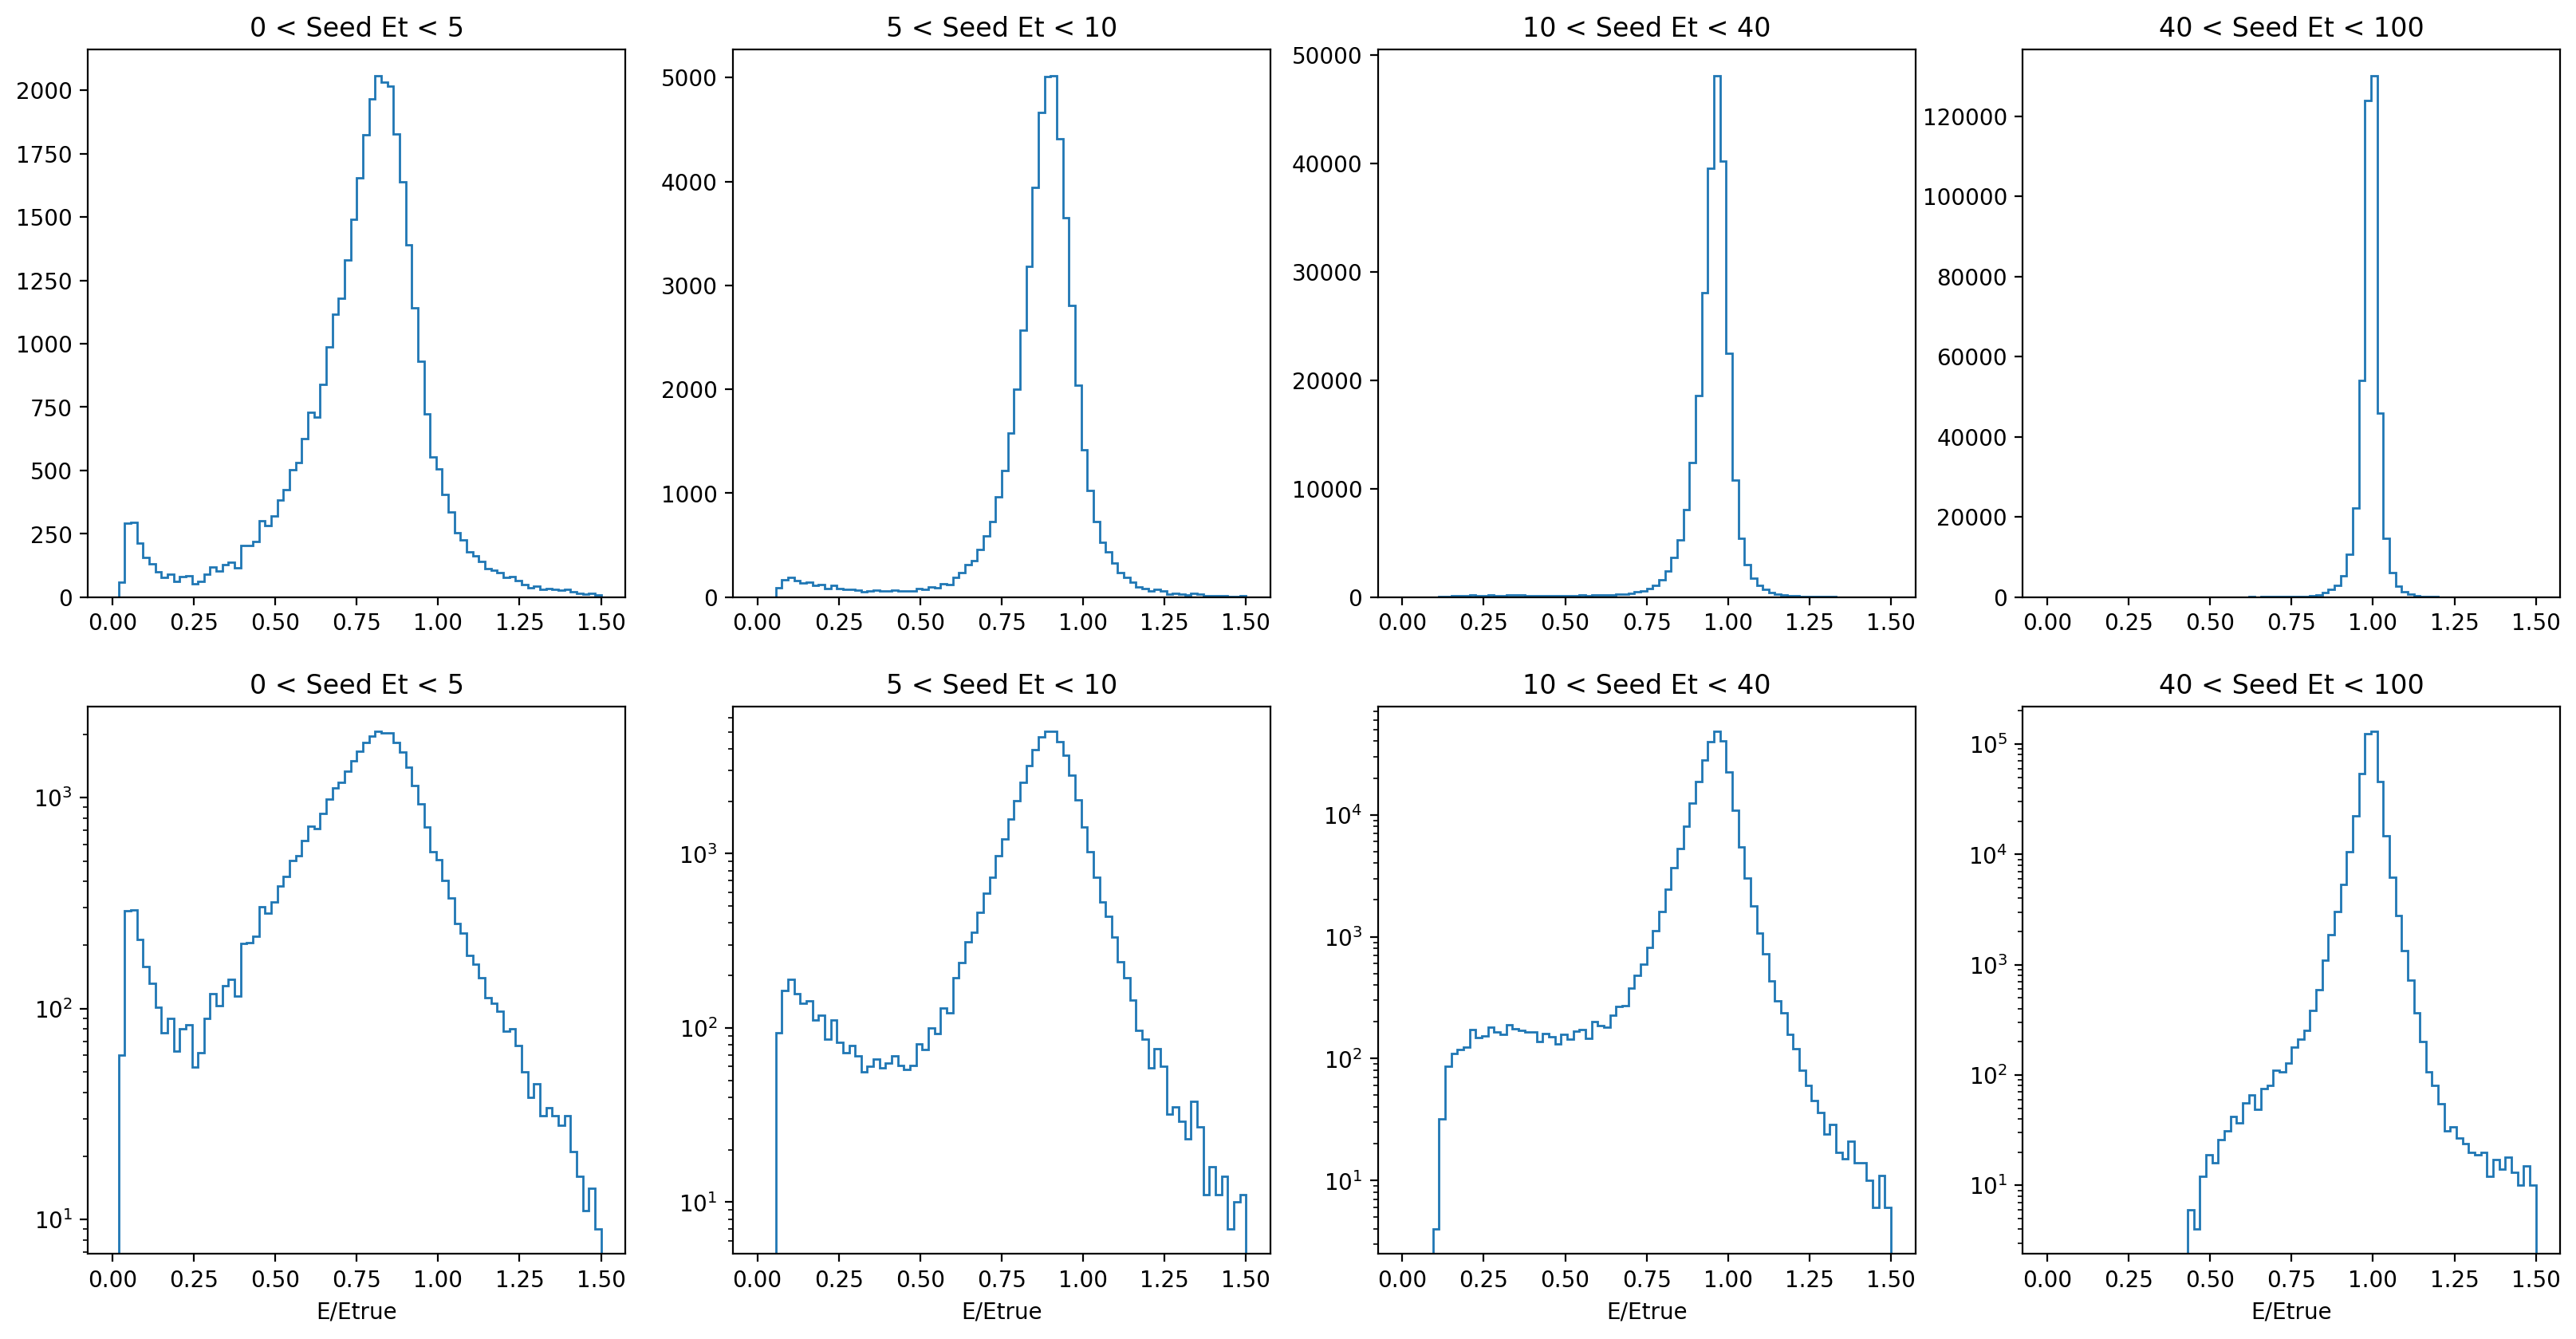

In [28]:
fig, ax = plt.subplots(2,4, figsize=(20,10),dpi=200)

ets = [ (0,5),(5,10),(10,40), (40,100)]

for j,(e1,e2) in enumerate(ets): 
    ax[0,j].hist(dfc[ (dfc.seed_et>=e1) & (dfc.seed_et<e2)].EoEtrue,bins=80, range=(0,1.5),histtype='step')
    ax[0,j].set_title('{} < Seed Et < {}'.format(e1,e2))   
    ax[1,j].hist(dfc[ (dfc.seed_et>=e1) & (dfc.seed_et<e2)].EoEtrue,bins=80, range=(0,1.5),histtype='step')
    ax[1,j].set_xlabel("E/Etrue")
    ax[1,j].set_title('{} < Seed Et < {}'.format(e1,e2))  
    ax[1,j].set_yscale('log')



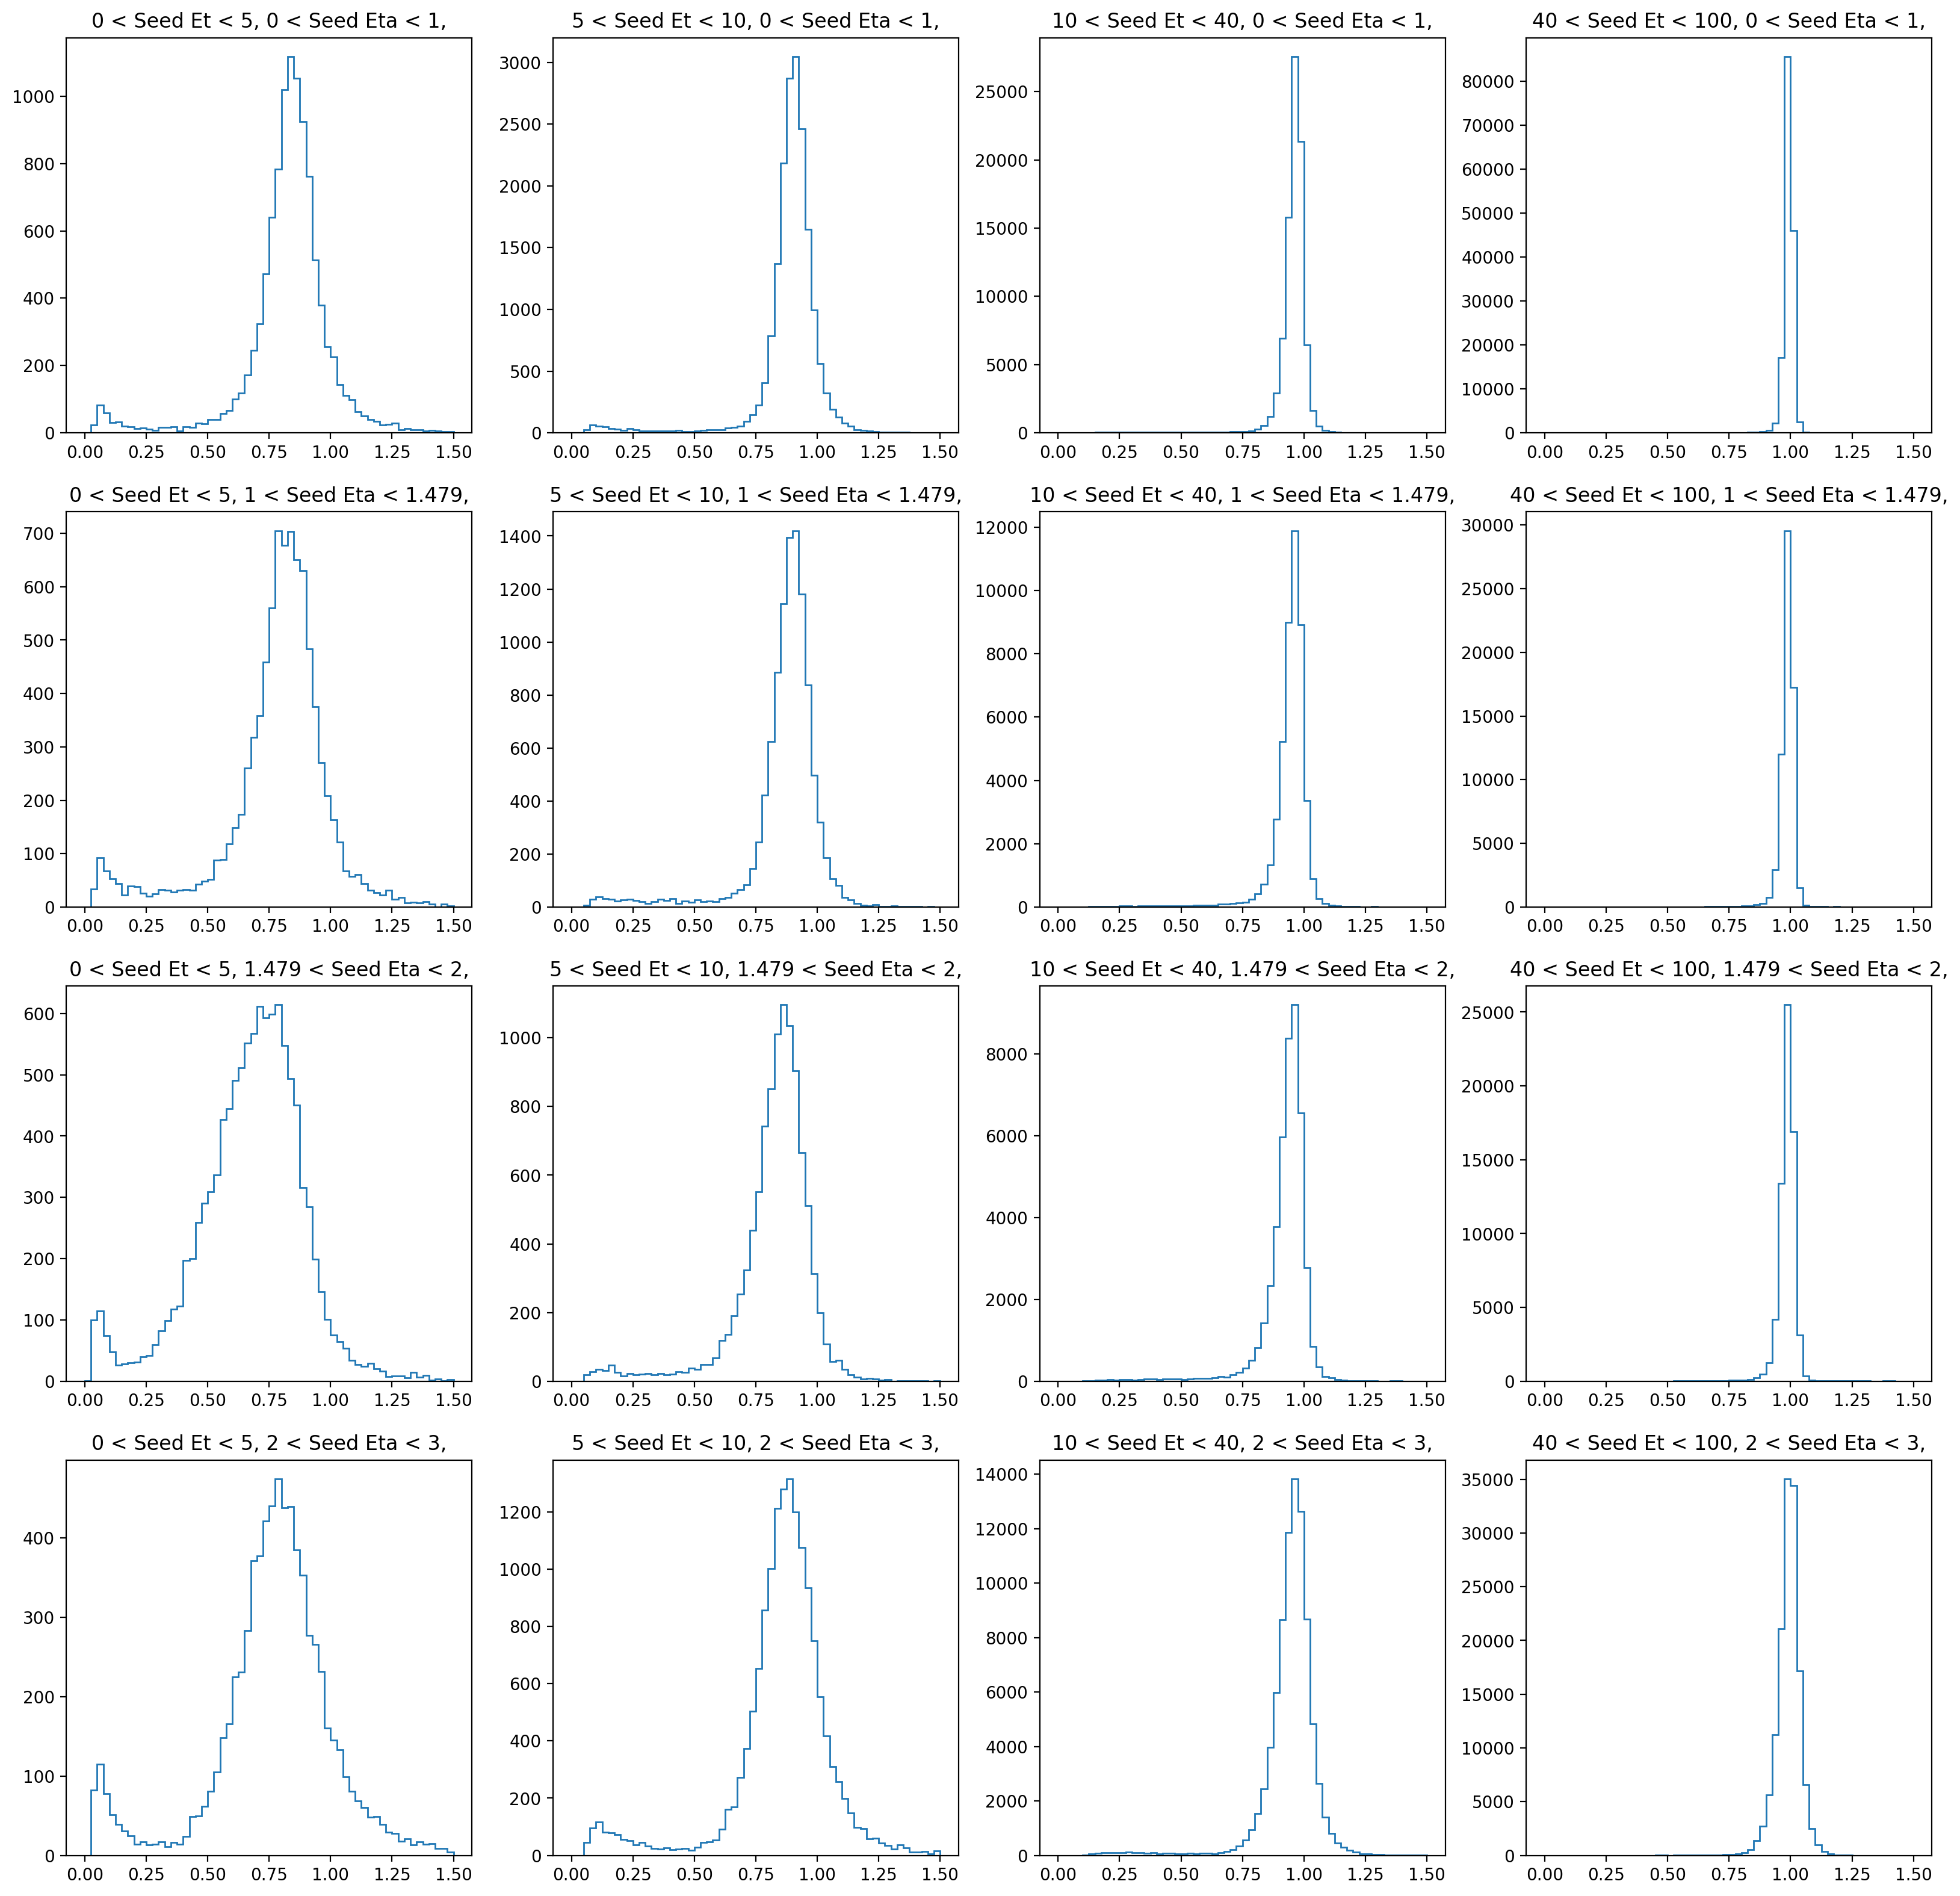

In [29]:
fig, ax = plt.subplots(4,4, figsize=(20,20),dpi=200)

ets = [ (0,5),(5,10),(10,40), (40,100)]
etas = [ (0,1),(1,1.479),(1.479,2), (2,3)]

for i,(ea1,ea2) in enumerate(etas):
    for j,(et1,et2) in enumerate(ets): 
        ax[i,j].hist(dfc[ (dfc.seed_et>=et1) & (dfc.seed_et<et2) \
                    & (abs(dfc.seed_eta)>=ea1) & (abs(dfc.seed_eta)<ea2)].EoEtrue,bins=60, range=(0,1.5),histtype='step')
        ax[i,j].set_title('{} < Seed Et < {}, {} < Seed Eta < {},'.format(et1,et2,ea1,ea2))   


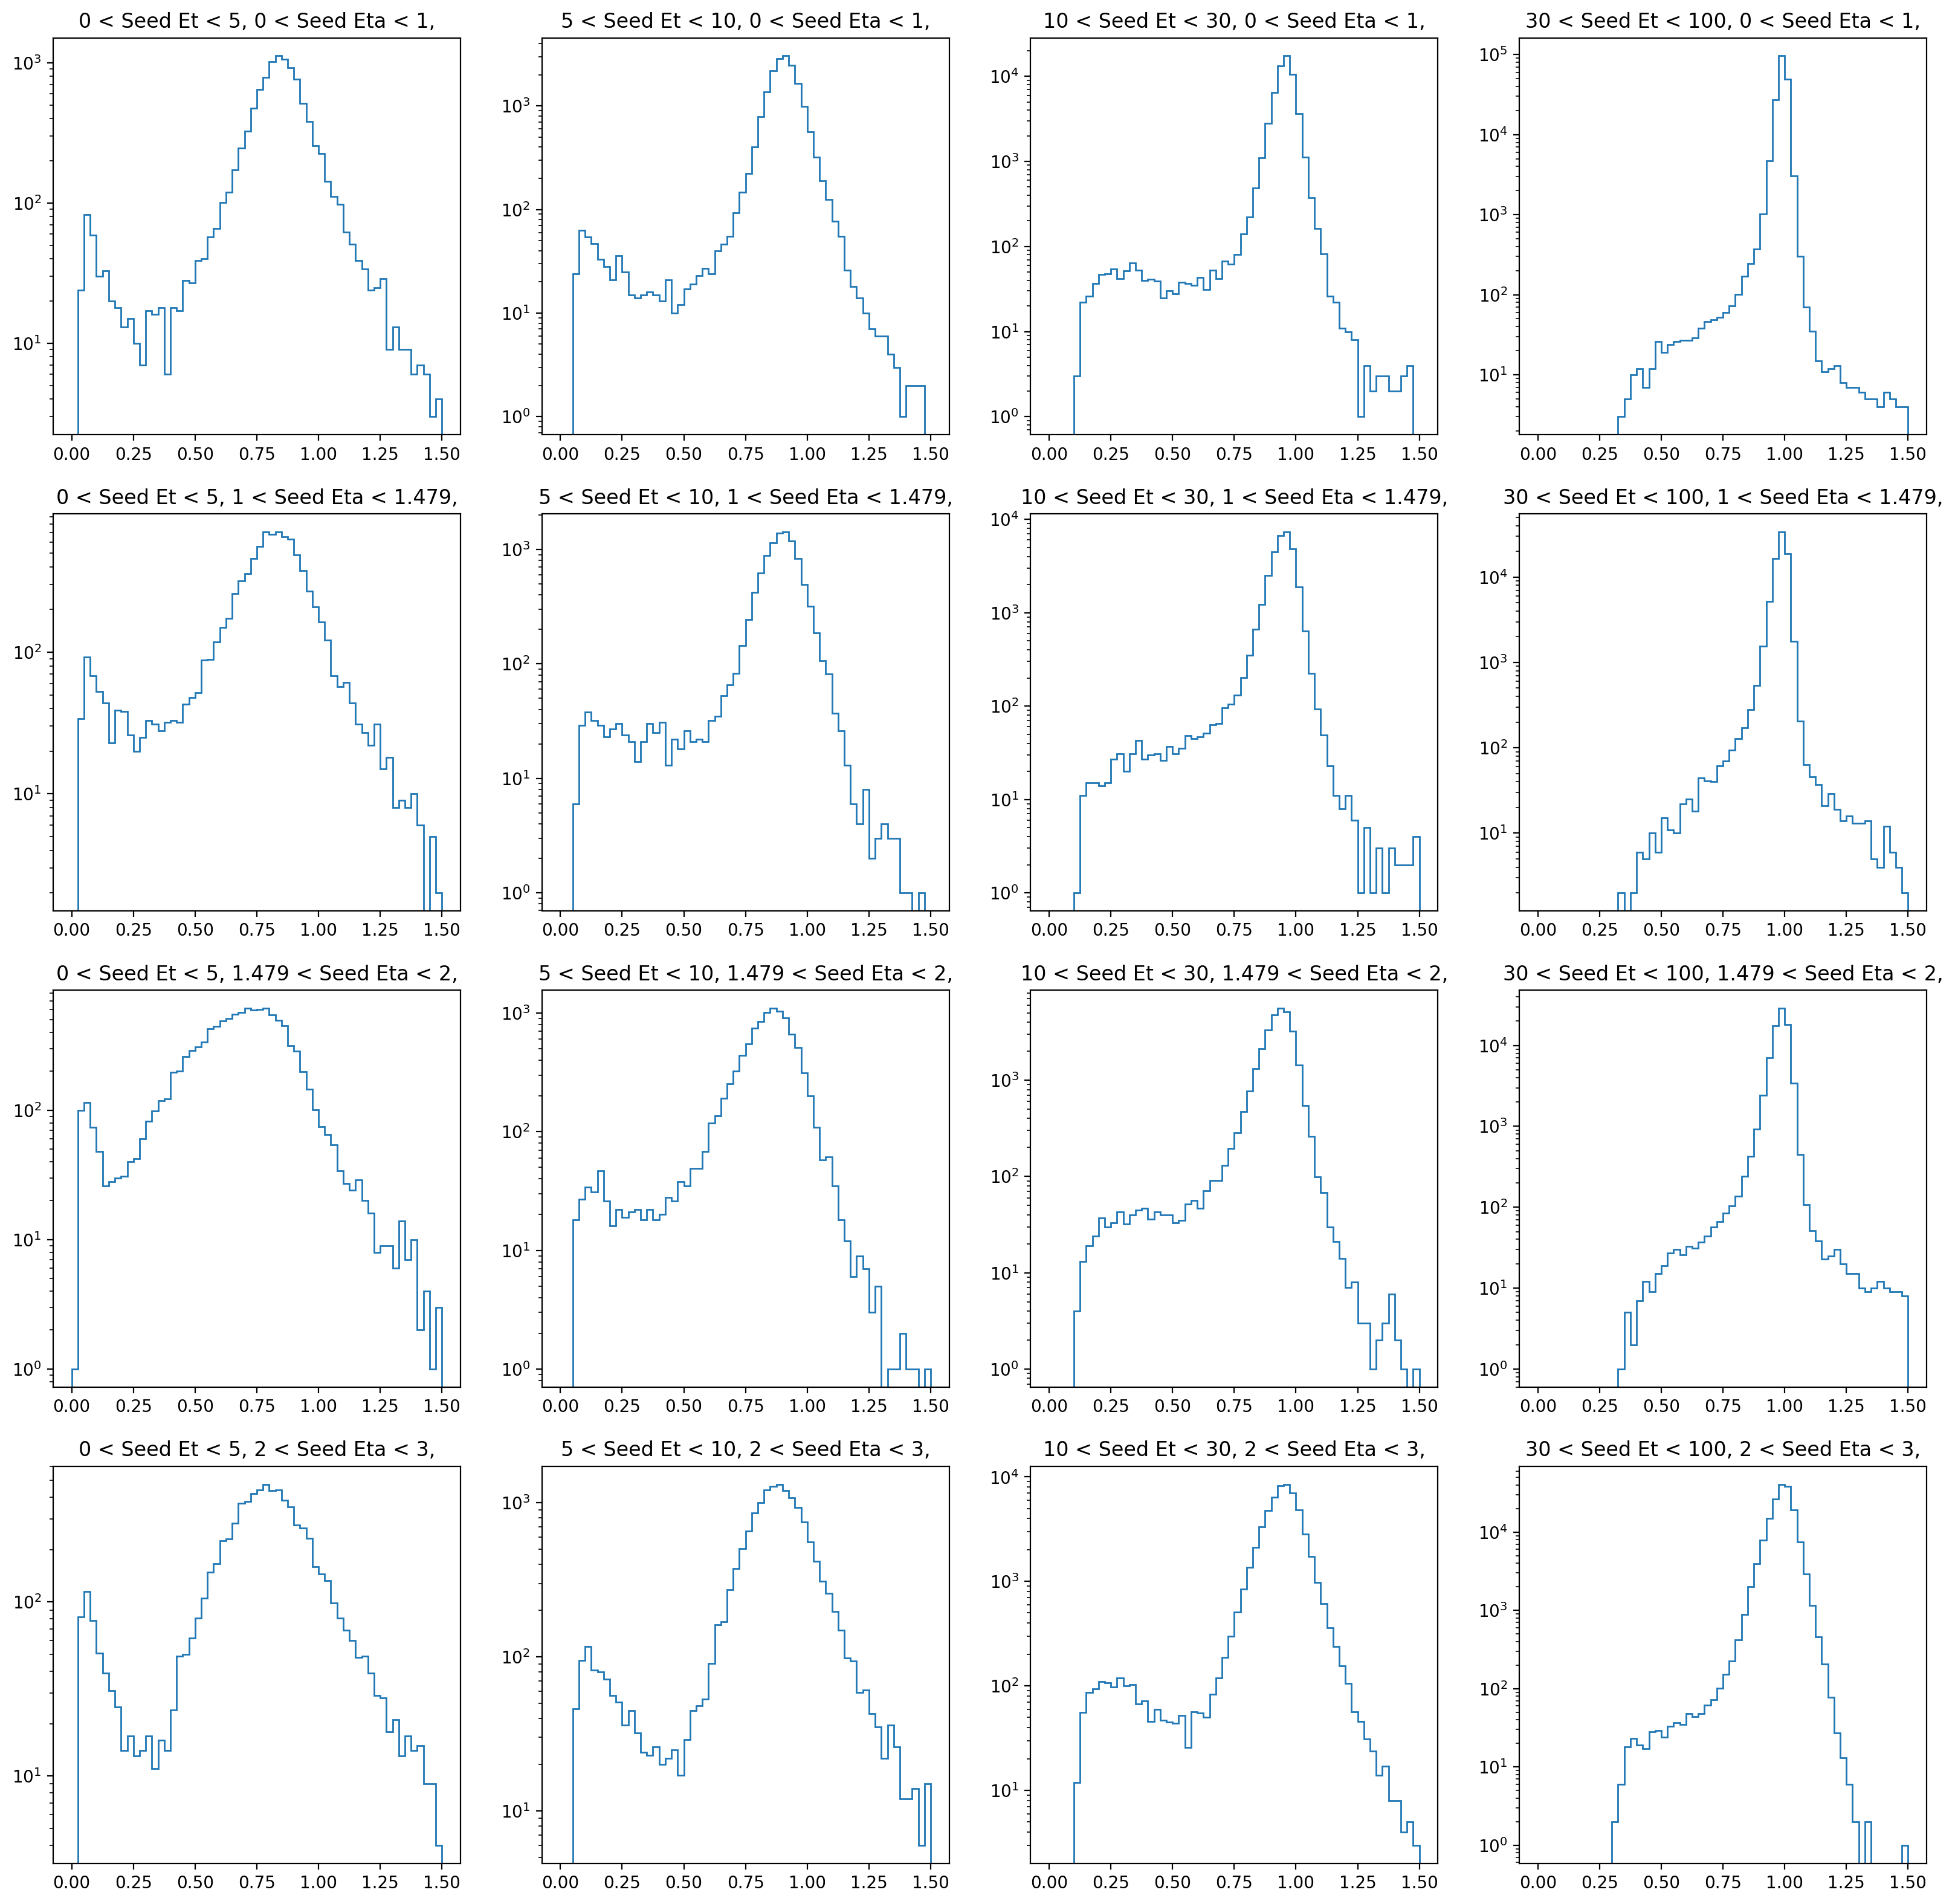

In [32]:
fig, ax = plt.subplots(4,4, figsize=(20,20),dpi=200)

ets = [ (0,5),(5,10),(10,30), (30,100)]
etas = [ (0,1),(1,1.479),(1.479,2), (2,3)]

for i,(ea1,ea2) in enumerate(etas):
    for j,(et1,et2) in enumerate(ets): 
        ax[i,j].hist(dfc[(dfc.seed_et>=et1) & (dfc.seed_et<et2) \
                             & (abs(dfc.seed_eta)>=ea1) & (abs(dfc.seed_eta)<ea2)].EoEtrue,bins=60, range=(0,1.5),histtype='step')
        ax[i,j].set_title('{} < Seed Et < {}, {} < Seed Eta < {},'.format(et1,et2,ea1,ea2))  
        ax[i,j].set_yscale('log')


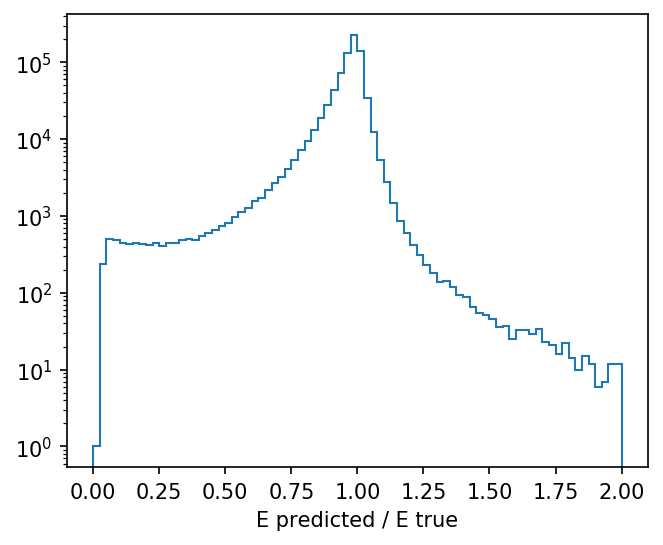

In [34]:
plt.hist(dfc.EoEtrue,bins=80, range=(0,2),histtype='step')

plt.xlabel("E predicted / E true")
plt.yscale("log")

Text(0.5, 0, 'E predicted / E true')

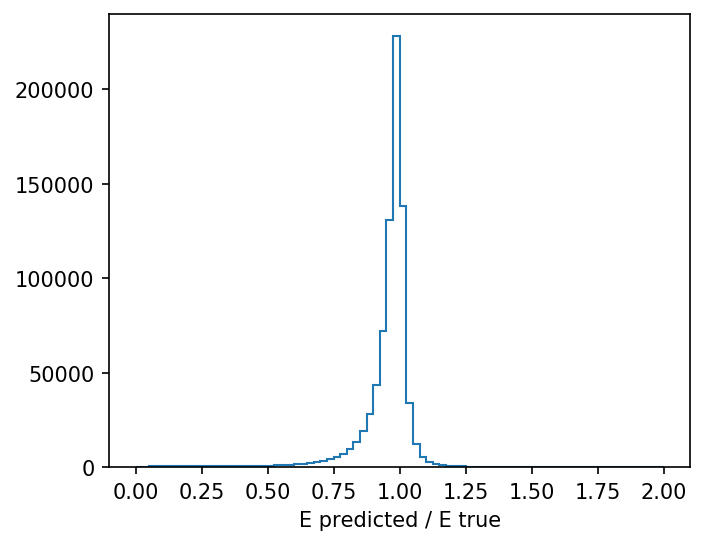

In [35]:
plt.hist(dfc.EoEtrue,bins=80, range=(0,2),histtype='step')

plt.xlabel("E predicted / E true")

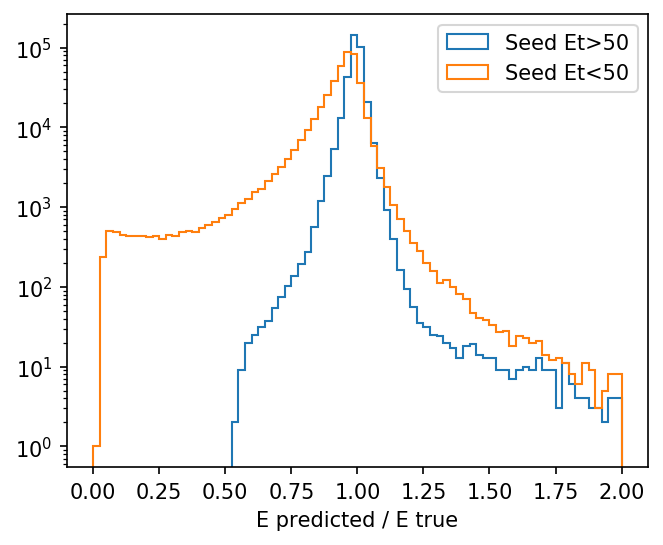

In [36]:
plt.hist(dfc[ (dfc.seed_et>50)].EoEtrue,bins=80, range=(0,2),histtype='step',label='Seed Et>50')
plt.hist(dfc[ (dfc.seed_et<=50)].EoEtrue,bins=80, range=(0,2),histtype='step',label='Seed Et<50')
plt.xlabel("E predicted / E true")
plt.yscale("log")
plt.legend()
#hep.cms.text("Simulation")
#hep.mpl_magic()

Text(0.5, 0, 'N. clusters')

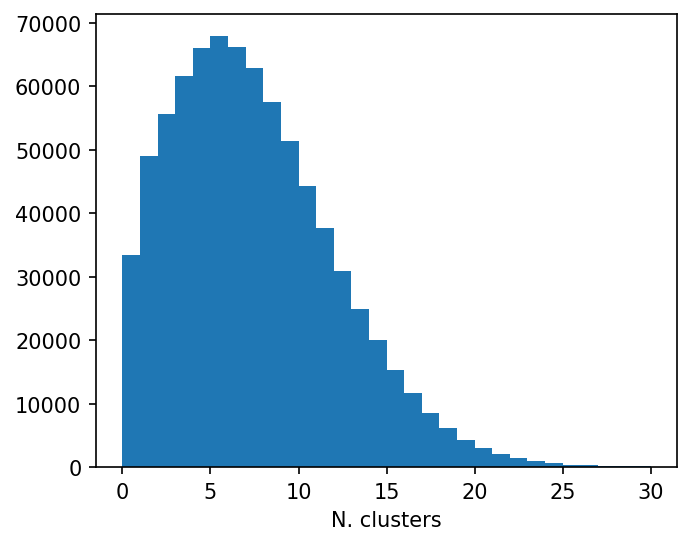

In [37]:
plt.hist(dfc.ncls, range=(0,30), bins=30)
plt.xlabel("N. clusters")

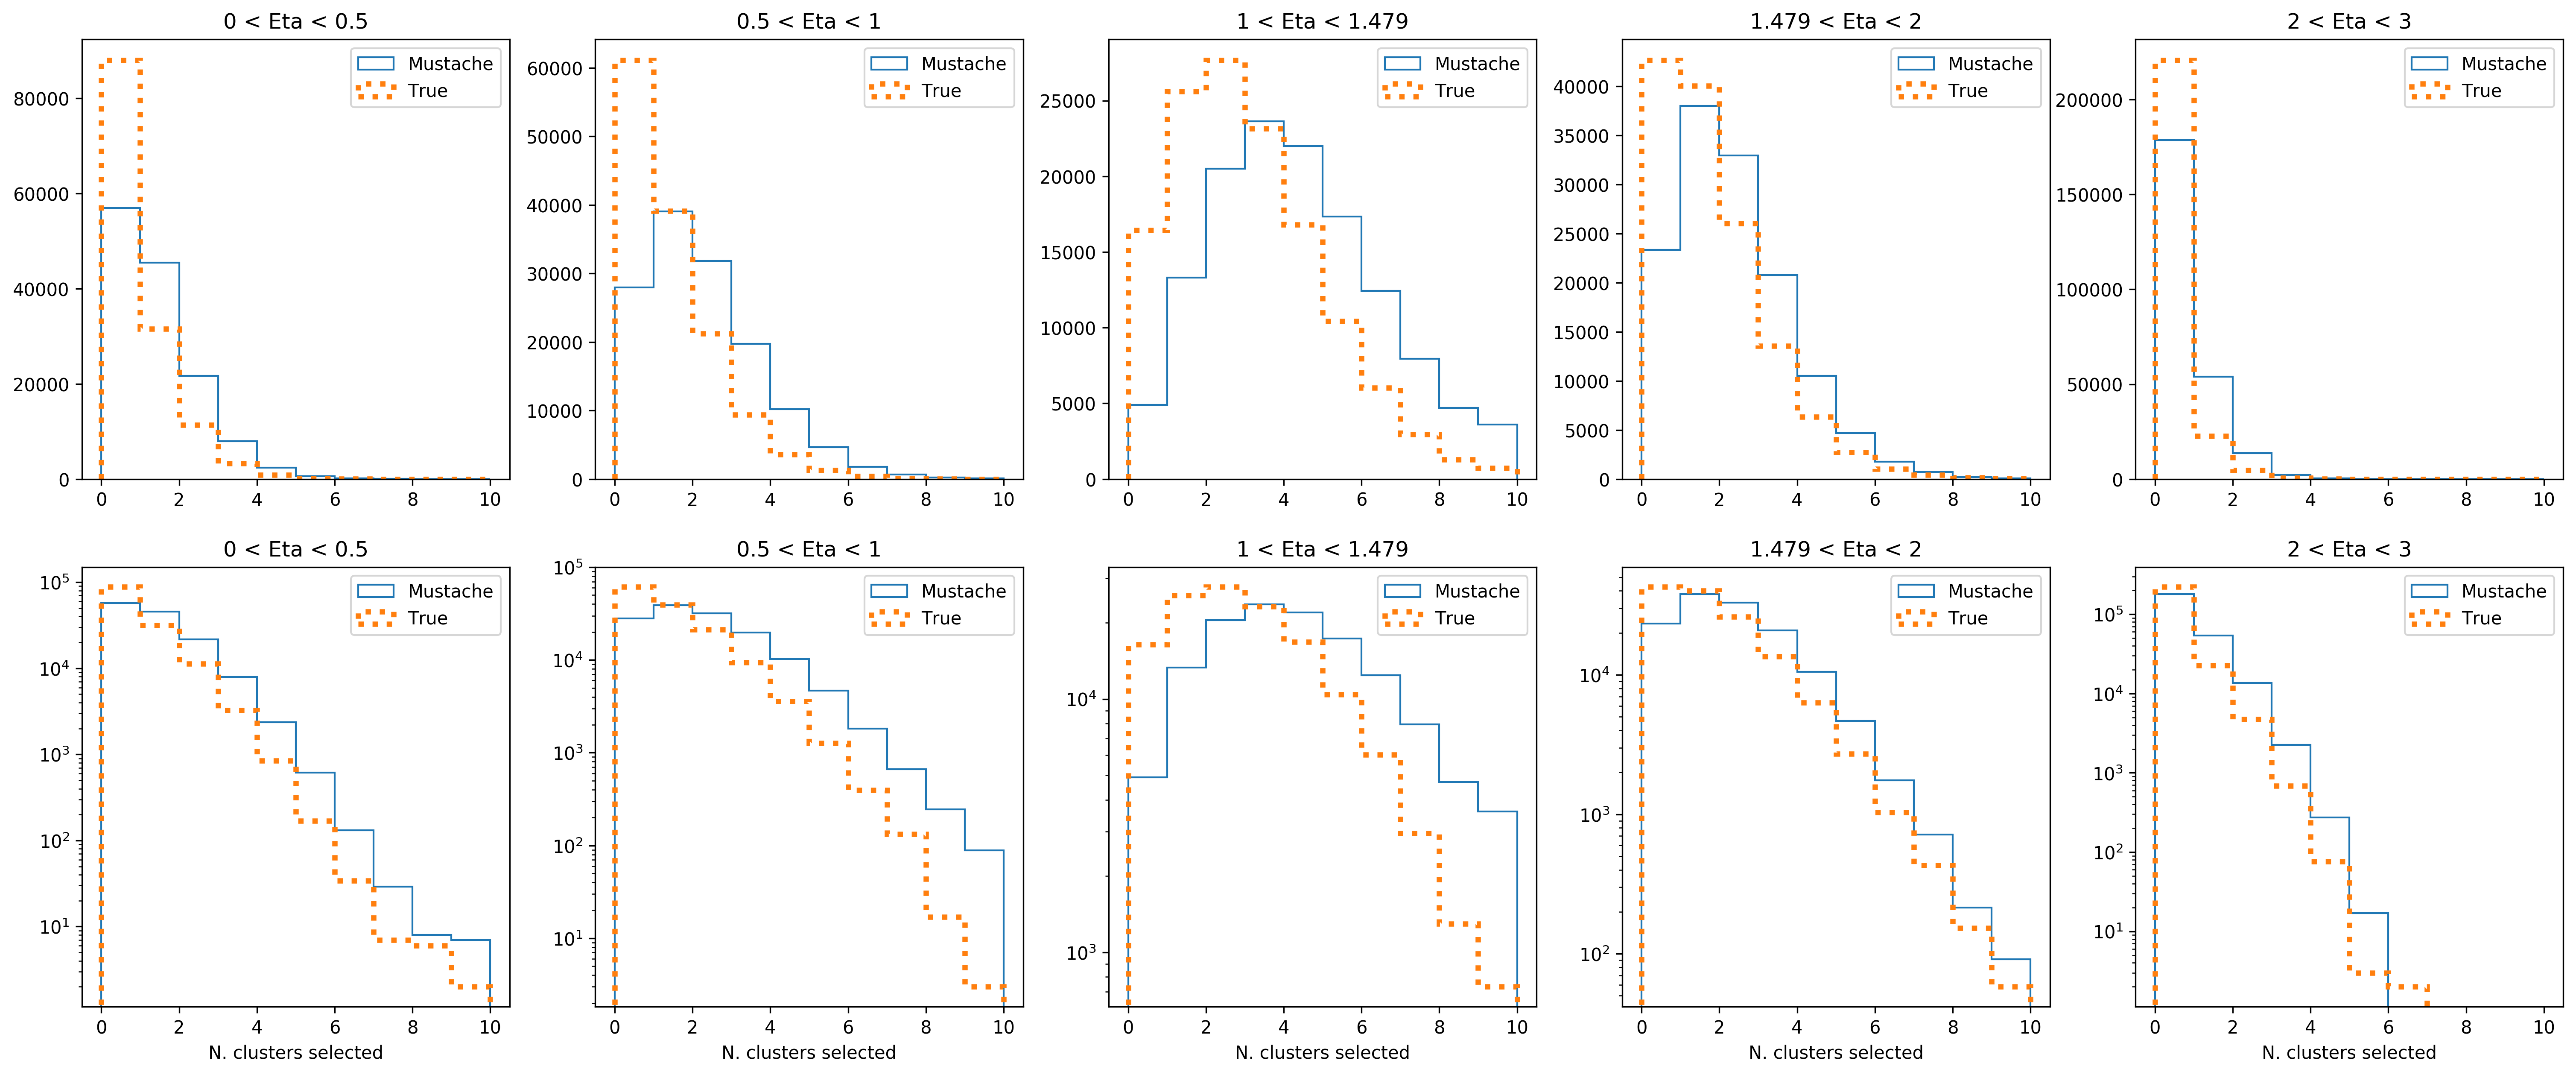

In [43]:
fig, ax = plt.subplots(2,5, figsize=(25,10),dpi=300)

etas = [ (0,0.5),(0.5,1),(1,1.479),(1.479,2), (2,3)]

for j,(e1,e2) in enumerate(etas): 
    ax[0,j].hist(dfc[(abs(dfc.seed_eta)>=e1) & (abs(dfc.seed_eta)<e2)].ncls_sel,bins=10, range=(0,10),histtype='step', label="Mustache")
    ax[0,j].set_title('{} < Eta < {}'.format(e1,e2))   
    ax[1,j].hist(dfc[ (abs(dfc.seed_eta)>=e1) & (abs(dfc.seed_eta)<e2)].ncls_sel,bins=10, range=(0,10),histtype='step', label="Mustache")

    ax[1,j].set_xlabel("N. clusters selected")
    ax[1,j].set_title('{} < Eta < {}'.format(e1,e2))  
    ax[1,j].set_yscale('log')
    ax[0,j].hist(dfc[(abs(dfc.seed_eta)>=e1) & (abs(dfc.seed_eta)<e2)].ncls_true,bins=10, range=(0,10),histtype='step', label='True', linewidth=3,linestyle=':')
    ax[1,j].hist(dfc[(abs(dfc.seed_eta)>=e1) & (abs(dfc.seed_eta)<e2)].ncls_true,bins=10, range=(0,10),histtype='step', label='True', linewidth=3,linestyle=':')
    ax[0,j].legend()
    ax[1,j].legend()

In [44]:
ets = [0,5,10,15, 20,40,60,80,100]
etas = [0, 0.4,0.8, 1.2,1.479, 1.75,2.,2.3,2.6,3]
ncls = [0,2,3,5,10,15,20,25,30,35,50]

def plot_eteta2D(data, title, zlabel="",**kwargs):

    a = data.values.reshape((len(etas)-1,len(ets)-1))

    plt.figure(figsize=(10,5))
    plt.imshow(a.T,**kwargs)
    plt.xlabel("Seed $\eta$")
    plt.ylabel("Seed $E_T$")
    plt.title(title)
    plt.colorbar(label=zlabel)

    plt.yticks(np.arange(len(ets)-1), ets)
    plt.xticks(np.arange(len(etas)-1), etas)

    locs, labels= plt.xticks()
    labels.append(etas[-1])
    locs = np.append(locs, [len(etas)-1])
    plt.xticks(locs-0.5, labels)

    locs, labels= plt.yticks()
    labels.append(ets[-1])
    locs = np.append(locs, [len(ets)-1])
    plt.yticks(locs-0.5, labels)

def plot_nclseta2D(data, title, zlabel="", **kwargs):

    a = data.values.reshape((len(etas)-1,len(ncls)-1))

    plt.figure(figsize=(10,5))
    plt.imshow(a.T, **kwargs)
    plt.xlabel("Seed $\eta$")
    plt.ylabel("N. clusters")
    plt.title(title)
    plt.colorbar(label=zlabel)

    plt.yticks(np.arange(len(ncls)-1), ncls)
    plt.xticks(np.arange(len(etas)-1), etas)

    locs, labels= plt.xticks()
    labels.append(etas[-1])
    locs = np.append(locs, [len(etas)-1])
    plt.xticks(locs-0.5, labels)

    locs, labels= plt.yticks()
    labels.append(ncls[-1])
    locs = np.append(locs, [len(ncls)-1])
    plt.yticks(locs-0.5, labels)

# Resolution plots

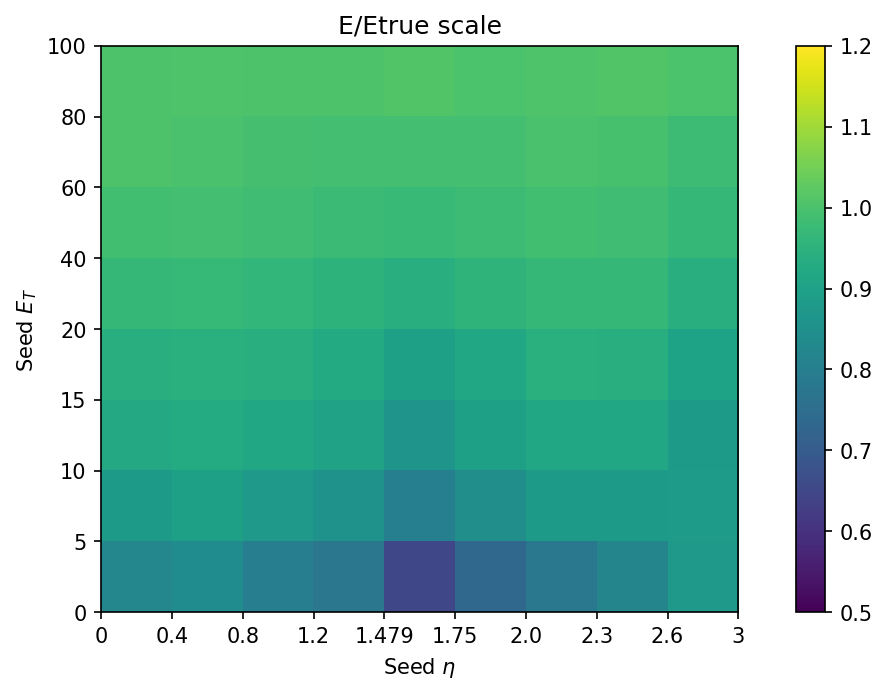

In [45]:
result =  dfc[ (dfc.Etrue>1)].groupby(["eta_bin", "et_bin"]).EoEtrue.mean()

plot_eteta2D(result,"E/Etrue scale", vmin=0.5, vmax=1.2)

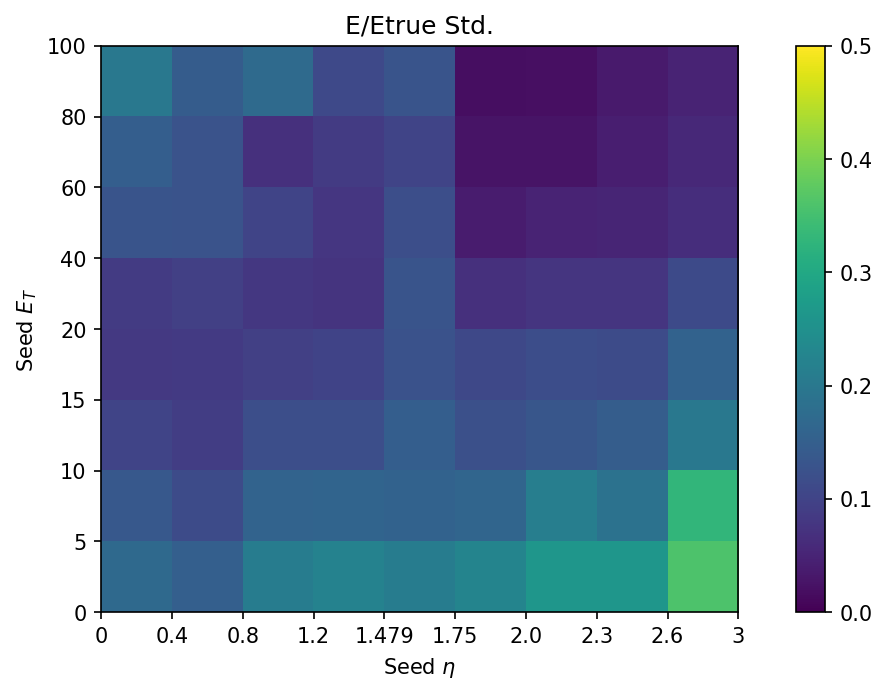

In [46]:
result =  dfc[(dfc.Etrue>5)].groupby(["eta_bin", "et_bin"]).EoEtrue.std()

plot_eteta2D(result,"E/Etrue Std.", vmin=0, vmax=0.5)

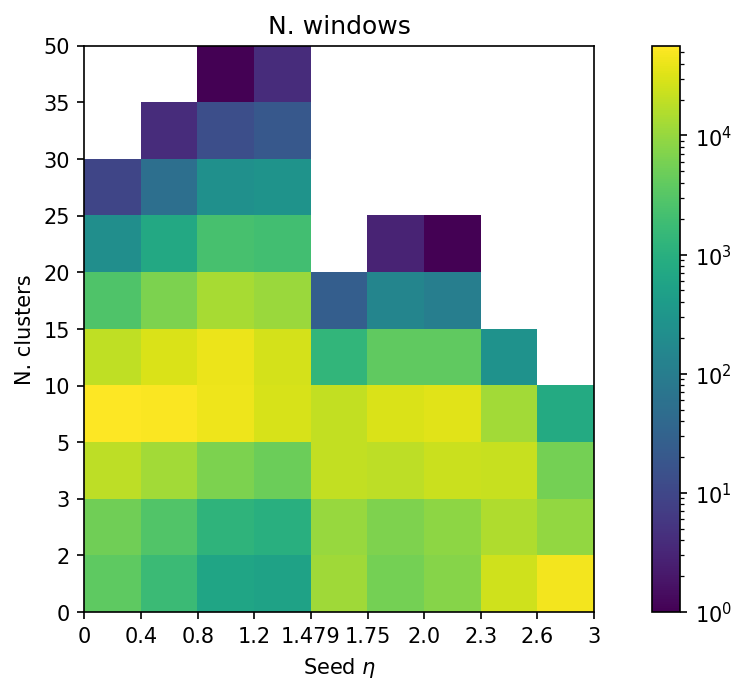

In [47]:
result =  dfc[ (dfc.Etrue>4)].groupby(["eta_bin", "ncls_bin"]).EoEtrue.count()

plot_nclseta2D(result,"N. windows", norm=colors.LogNorm())

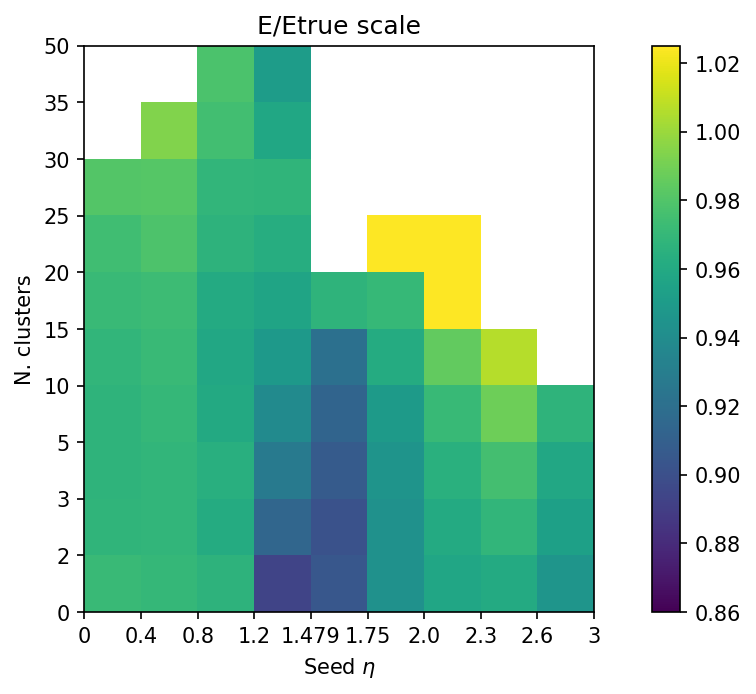

In [48]:
result =  dfc[(dfc.Etrue>4)].groupby(["eta_bin", "ncls_bin"]).EoEtrue.mean()

plot_nclseta2D(result,"E/Etrue scale", vmin=0.86, vmax=1.025)

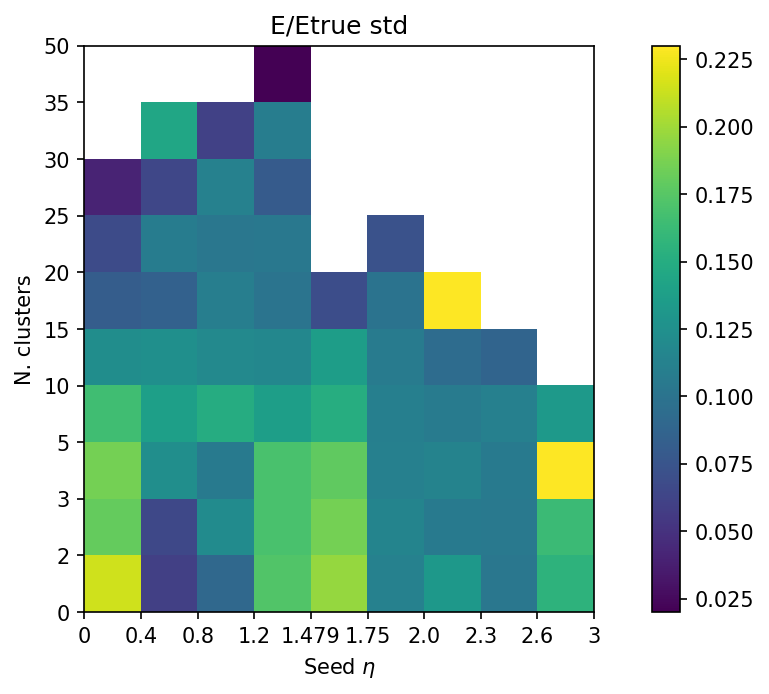

In [49]:
result =  dfc[ (dfc.Etrue>4)].groupby(["eta_bin", "ncls_bin"]).EoEtrue.std()

plot_nclseta2D(result,"E/Etrue std", vmin=0.02, vmax=0.23)

# Classification metric

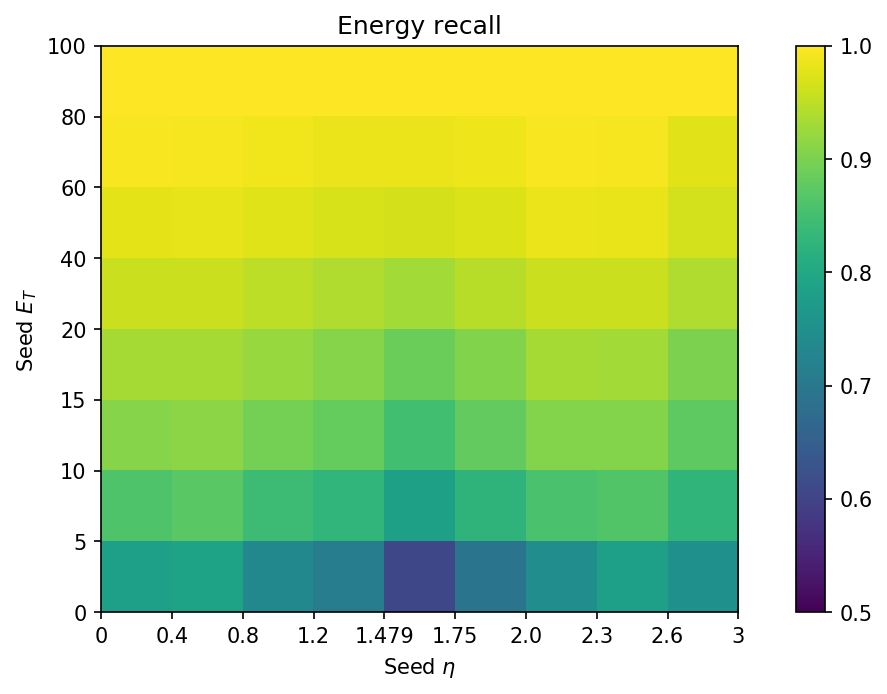

In [50]:
result =  dfc[(dfc.Etrue>4)].groupby(["eta_bin", "et_bin"]).apply( lambda gr:  (gr.E_tp / gr.Etrue).mean())
plot_eteta2D(result,"Energy recall",vmin=0.5, vmax=1)

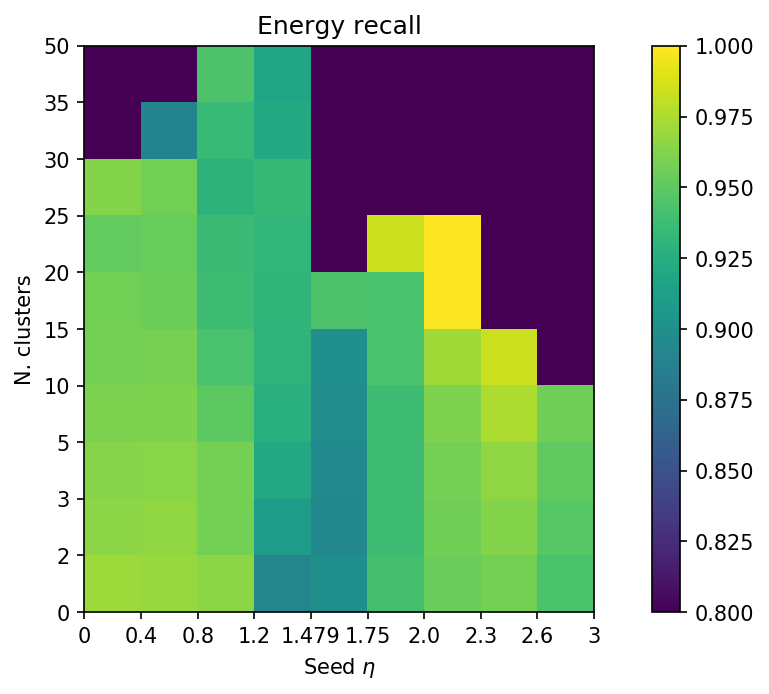

In [51]:
result =  dfc[(dfc.Etrue>4)].groupby(["eta_bin", "ncls_bin"]).apply( lambda gr:  (gr.E_tp / gr.Etrue).mean()).unstack(fill_value=0).stack()
plot_nclseta2D(result,"Energy recall", vmin=0.8, vmax=1)

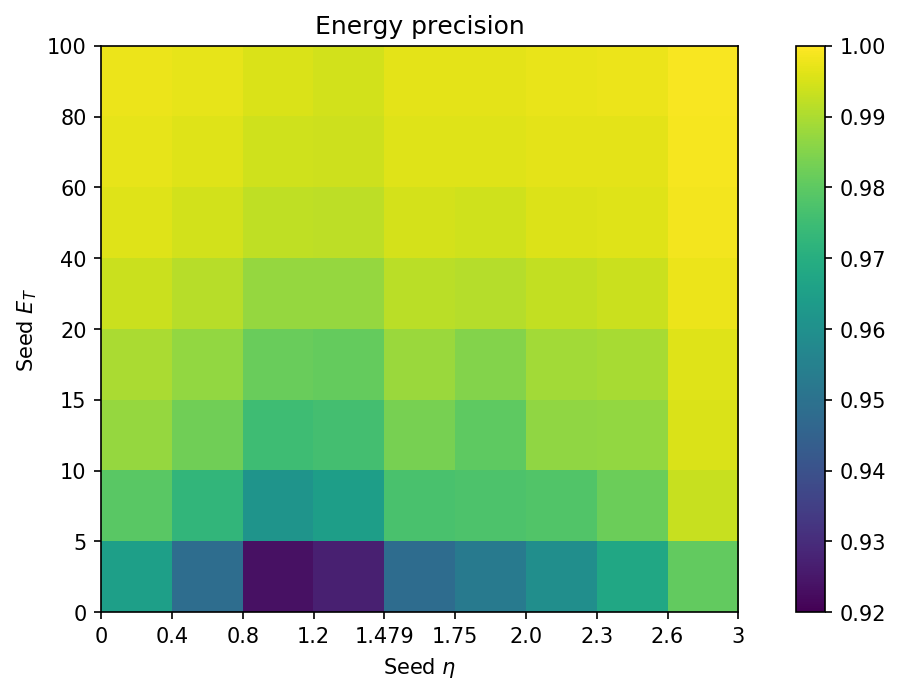

In [56]:
result =  dfc[(dfc.Etrue>4)].groupby(["eta_bin", "et_bin"]).apply( lambda gr:  (gr.E_tp / gr.Epred).mean())
plot_eteta2D(result,"Energy precision", vmin=0.92, vmax=1)

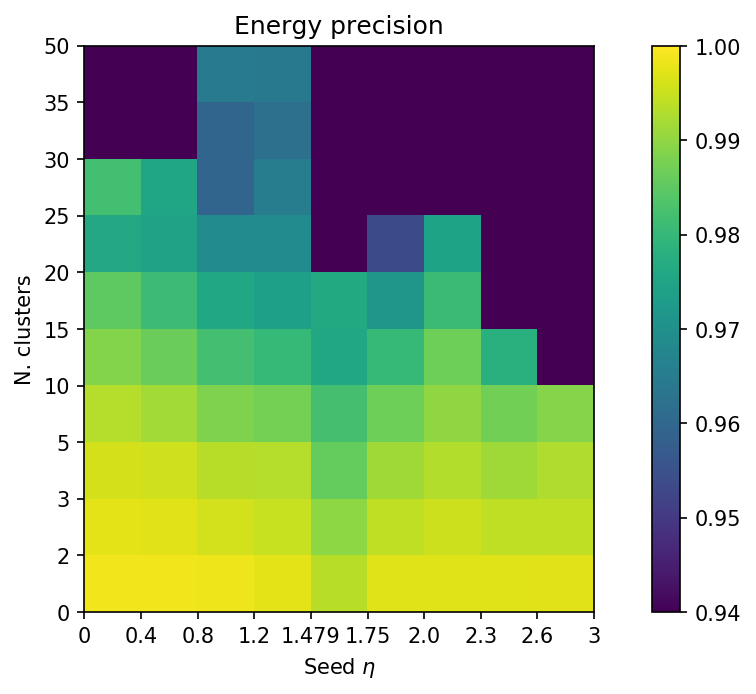

In [58]:
result =  dfc[(dfc.Etrue>4)].groupby(["eta_bin", "ncls_bin"])\
       .apply(lambda gr:  (gr.E_tp / gr.Epred).mean())\
       .unstack(fill_value=0).stack()
plot_nclseta2D(result,"Energy precision", vmin=0.94, vmax=1)

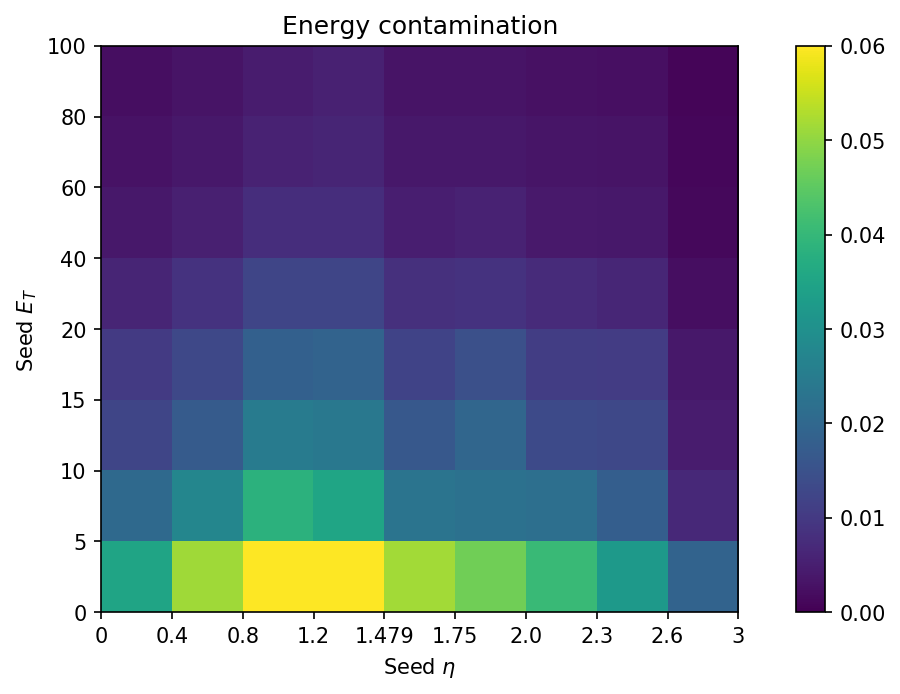

In [63]:
result =  dfc[(dfc.Etrue>4)].groupby(["eta_bin", "et_bin"]).apply( lambda gr:  (gr.E_fp / gr.Epred).mean())

plot_eteta2D(result,"Energy contamination", vmin=0, vmax=0.06)

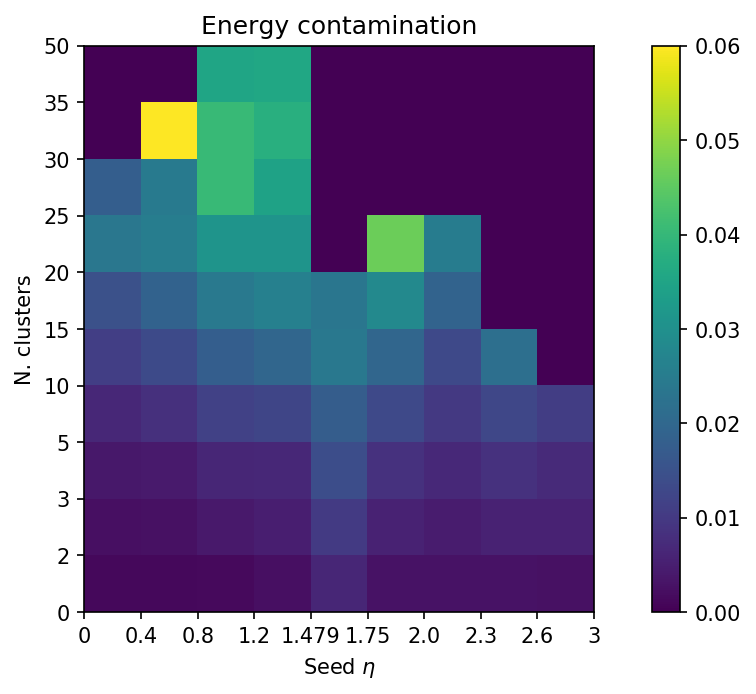

In [64]:
result =  dfc[(dfc.Etrue>4)].groupby(["eta_bin", "ncls_bin"])\
       .apply(lambda gr:  (gr.E_fp / gr.Epred).mean())\
       .unstack(fill_value=0).stack()
plot_nclseta2D(result,"Energy contamination", vmin=0, vmax=0.06)

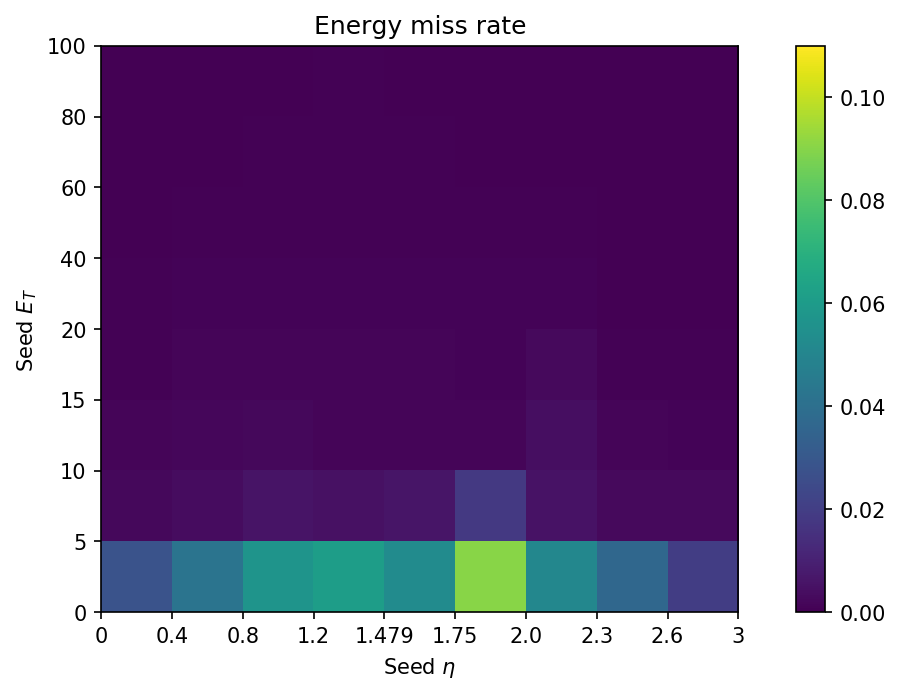

In [94]:
result =  dfc[(dfc.thres==0.8)&(dfc.Etrue>4)].groupby(["eta_bin", "et_bin"]).apply( lambda gr:  (gr.E_fn / gr.Etrue).mean())

plot_eteta2D(result,"Energy miss rate", vmin=0, vmax=0.11)

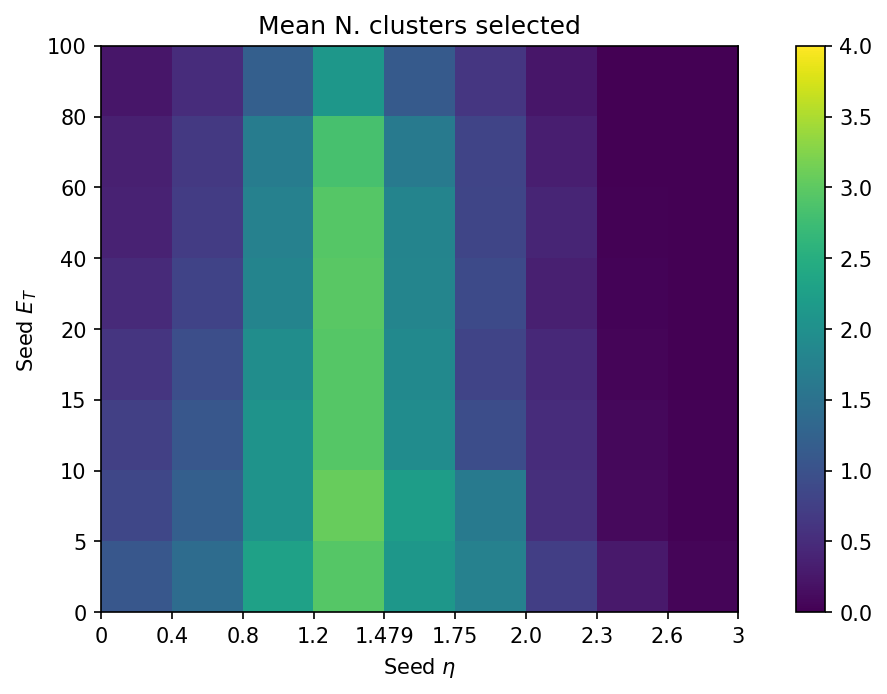

In [65]:
result =  dfc[(dfc.Etrue>4) ].groupby(["eta_bin", "et_bin"]).ncls_true.mean()

plot_eteta2D(result,"Mean N. clusters selected", vmin=0, vmax=4)

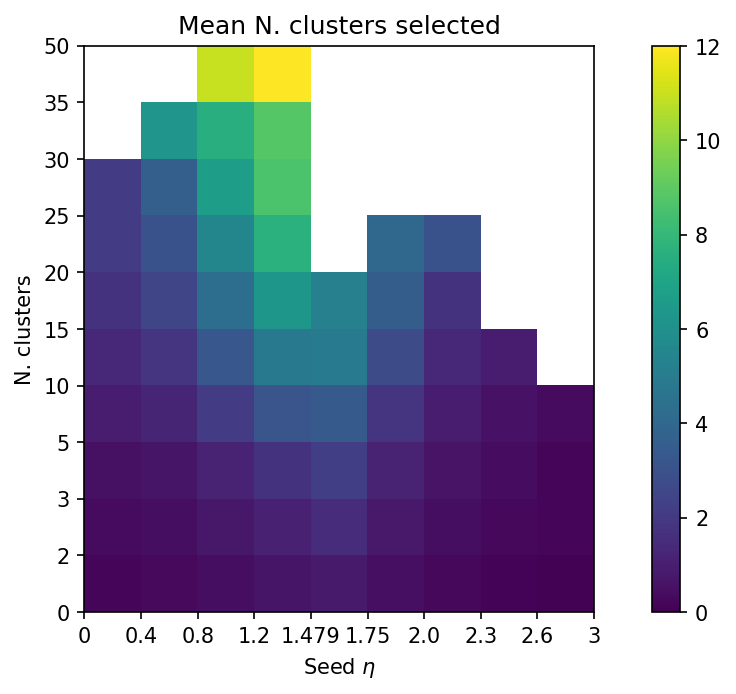

In [86]:
result =  dfc[(dfc.Etrue>4)].groupby(["eta_bin", "ncls_bin"]).ncls_sel.mean()

plot_nclseta2D(result,"Mean N. clusters selected", vmin=0, vmax=12)

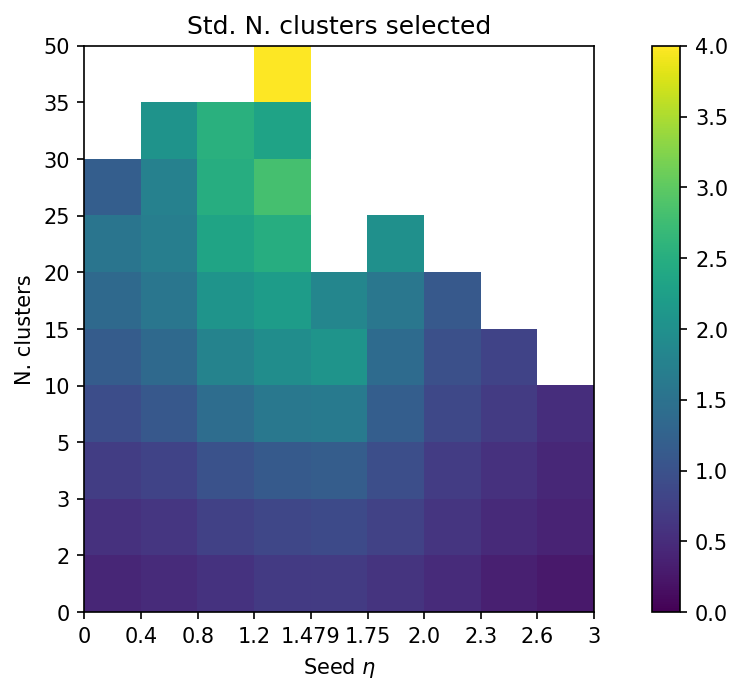

In [88]:
result =  dfc[(dfc.Etrue>4)].groupby(["eta_bin", "ncls_bin"]).ncls_sel.std()

plot_nclseta2D(result,"Std. N. clusters selected", vmin=0, vmax=4)

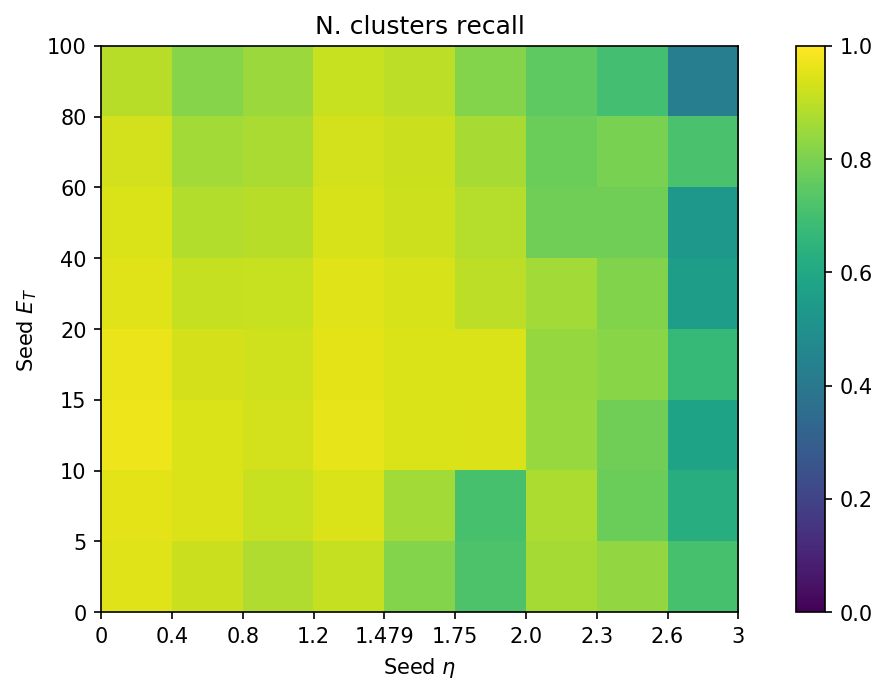

In [68]:
result =  dfc[(dfc.Etrue>4) & (dfc.ncls_true >0)].groupby(["eta_bin", "et_bin"]).apply( lambda gr:  (gr.ncls_sel_true / gr.ncls_true).mean())

plot_eteta2D(result,"N. clusters recall", vmin=0, vmax=1)

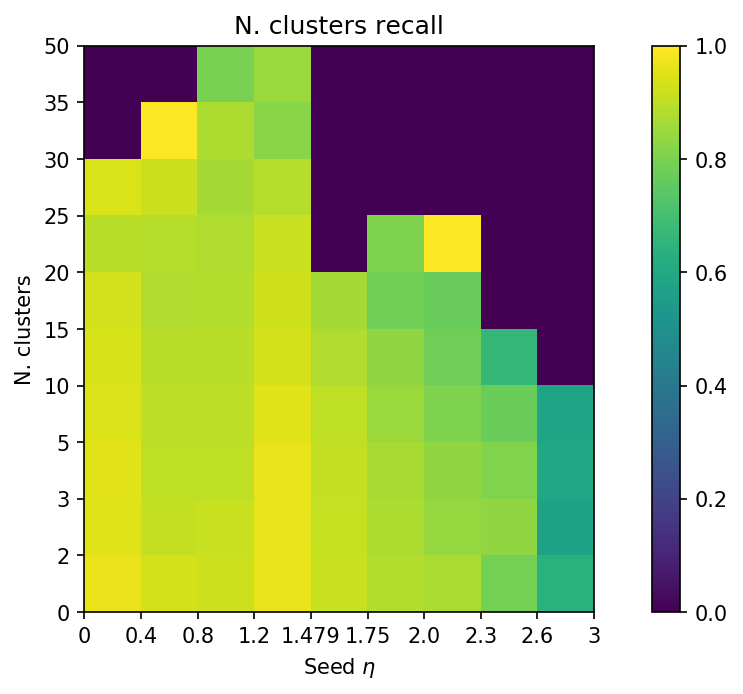

In [97]:
result =  dfc[(dfc.Etrue>4) & (dfc.ncls_true >0)].groupby(["eta_bin", "ncls_bin"])\
             .apply( lambda gr:  (gr.ncls_sel_true / gr.ncls_true).mean())\
             .unstack(fill_value=0).stack()

plot_nclseta2D(result,"N. clusters recall", vmin=0, vmax=1)

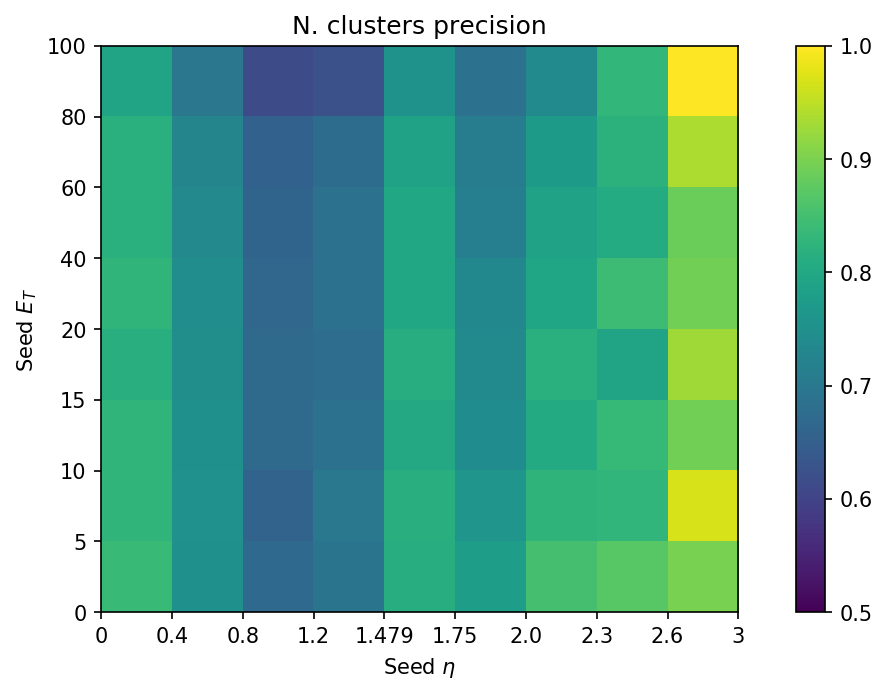

In [90]:
result =  dfc[(dfc.Etrue>4) & (dfc.ncls_true >0)].groupby(["eta_bin", "et_bin"])\
            .apply( lambda gr:  (gr.ncls_sel_true / gr.ncls_sel).mean())
plot_eteta2D(result,"N. clusters precision", vmin=0.5, vmax=1)

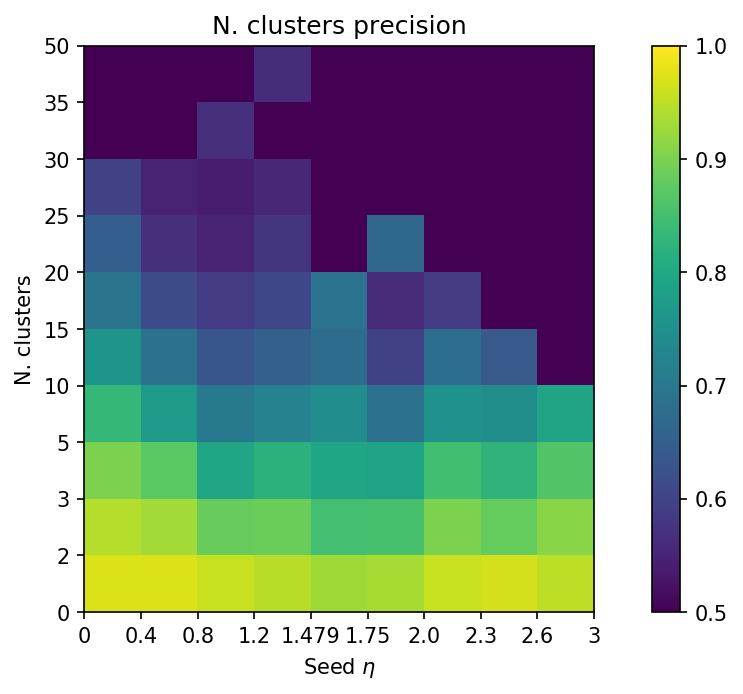

In [91]:
result =  dfc[(dfc.Etrue>4) & (dfc.ncls_true >0)].groupby(["eta_bin", "ncls_bin"])\
             .apply( lambda gr:  (gr.ncls_sel_true / gr.ncls_sel).mean())\
             .unstack(fill_value=0).stack()

plot_nclseta2D(result,"N. clusters precision",vmin=0.5, vmax=1)

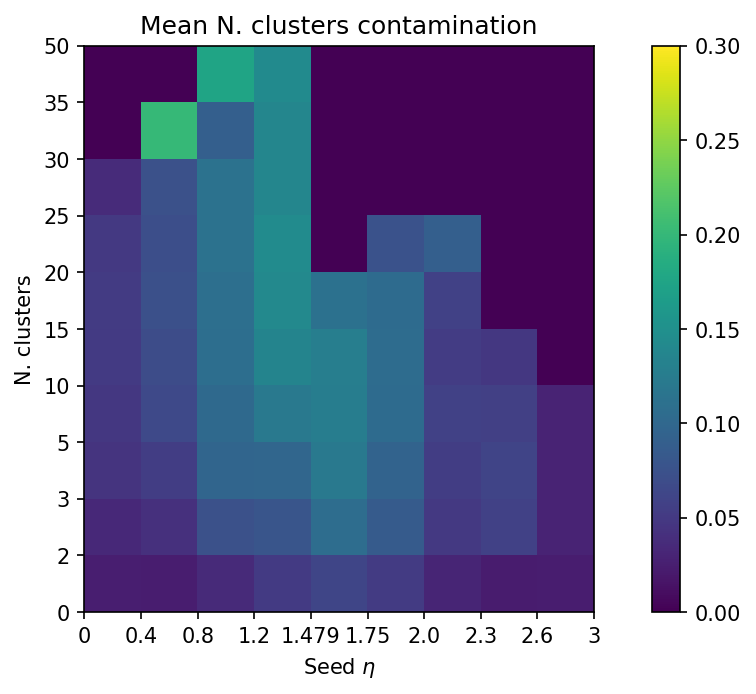

In [96]:
result =  dfc[(dfc.Etrue>4) & (dfc.ncls_true >0)].groupby(["eta_bin", "ncls_bin"])\
        .apply( lambda gr:  (( gr.ncls_sel - gr.ncls_sel_true)/gr.ncls) .mean())\
       .unstack(fill_value=0).stack()

plot_nclseta2D(result,"Mean N. clusters contamination", vmin=0,vmax=0.3)